# БЫТОВЫЕ УСЛУГИ. Исследование удовлетворённости клиента.
*Группа 03: Булдаков Арсений, Лебедев Фёдор, Плюхин Антон*

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as stats
import itertools
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder

In [2]:
df = pd.read_csv('Данные по использованию климатических систем.csv', sep=';')

In [3]:
# Найстройка графиков

params = {'text.color': "white", "font.size": 12}
plt.rcParams.update(params)
plt.tight_layout()
sns.set(style="whitegrid", font_scale=1.5)

<Figure size 640x480 with 0 Axes>

In [4]:
# PEP8

def make_word_pep8style(word: str) -> str:
    return word.lower().replace(' ', '_')

df = df.rename(make_word_pep8style, axis='columns')

list(df.columns)

['год',
 'время_года',
 'климат',
 'город',
 'страна',
 'способ_охлаждения',
 'режим_при_смешанном_типе_охлаждения',
 'способ_обогрева',
 'возраст',
 'пол',
 'ощущение_температуры',
 'ощущение_температуры_(bool)',
 'предпочтительное_изменение_температуры',
 'ощущение_движения_воздуха_(bool)',
 'предпочтительное_изменение_движения_воздуха',
 'оценка_комфорта',
 'утепление',
 'температура_воздуха_в_помещении',
 'температура_воздуха_на_улице',
 'rh',
 'скорость_воздуха',
 'рост',
 'вес',
 'занавески',
 'вентилятор',
 'окно',
 'двери',
 'отопление',
 'среднемесячная_температура_на_улице',
 'количество_рекламаций']

# Исследование данных на качество и предобработка

Разделим данные на числовые и категориальные, чтобы в дальнейшем было удобно использовать эти списки в наших вычислениях

In [5]:
numerical = [
    'возраст',
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'rh',
    'скорость_воздуха',
    'рост',
    'вес',
    'среднемесячная_температура_на_улице',
    'количество_рекламаций',
    'утепление',
    'ощущение_температуры',
    'оценка_комфорта',
]
categorial = list(set(df.columns) ^ set(numerical))

categorial_bool = [
    'ощущение_температуры_(bool)',
    'занавески',
    'вентилятор',
    'окно',
    'двери',
    'отопление'
]

Рассмотрим типы данных в столбцах

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 484 entries, 0 to 483
Data columns (total 30 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   год                                          484 non-null    float64
 1   время_года                                   484 non-null    object 
 2   климат                                       484 non-null    object 
 3   город                                        484 non-null    object 
 4   страна                                       484 non-null    object 
 5   способ_охлаждения                            484 non-null    object 
 6   режим_при_смешанном_типе_охлаждения          337 non-null    object 
 7   способ_обогрева                              222 non-null    object 
 8   возраст                                      413 non-null    float64
 9   пол                                          412 non-null    object 
 10  ощ

Год представлен типом **float64**, поэтому переведём его в **int**

In [7]:
df['год'] = df['год'].astype(int)

Остальные данные можно не изменять и использовать дальше в нашем исследовании

## Первичный графический анализ

Для поиска аномалий, выбросов используем графический метод: в категориальных факторах используем круговую диаграмму, а в количественных гистограммы и ящик с усами (boxplot)

### Для каждого числового столбца построим гистограмму и ящик с усамии

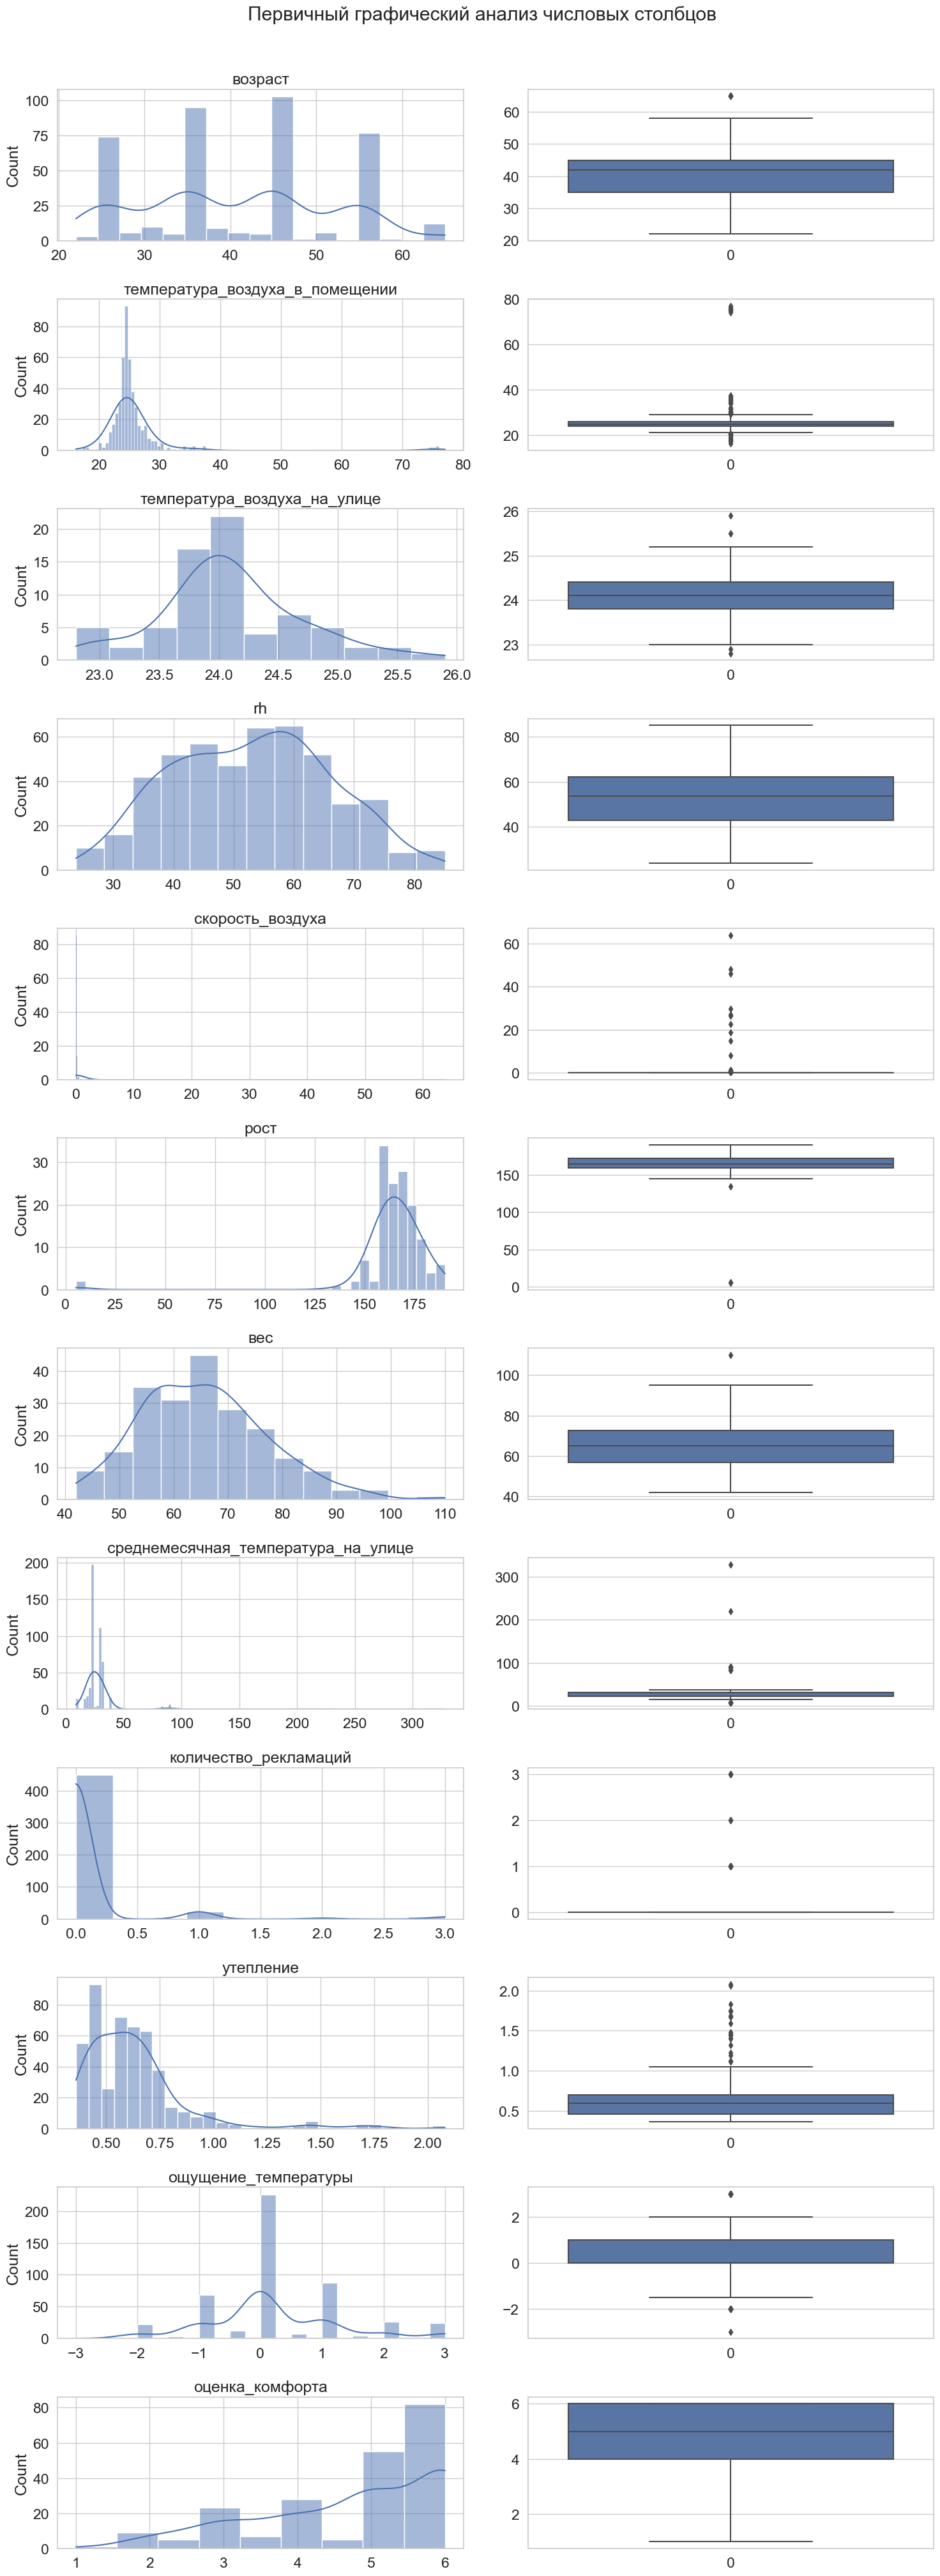

In [8]:
fig, ax = plt.subplots(len(numerical), 2)
fig.set_figheight(40)
fig.set_figwidth(15)
fig.suptitle("Первичный графический анализ числовых столбцов", y=1.01)
fig.tight_layout(h_pad=2)

for i, col in enumerate(numerical):
    sns.histplot(df[col], kde=True, ax=ax[i][0])
    sns.boxplot(df[col], ax=ax[i][1])
    ax[i][0].set_xlabel("")
    ax[i][0].set_title(col)

Для каждого категориального столбца построим круговую диаграмму:

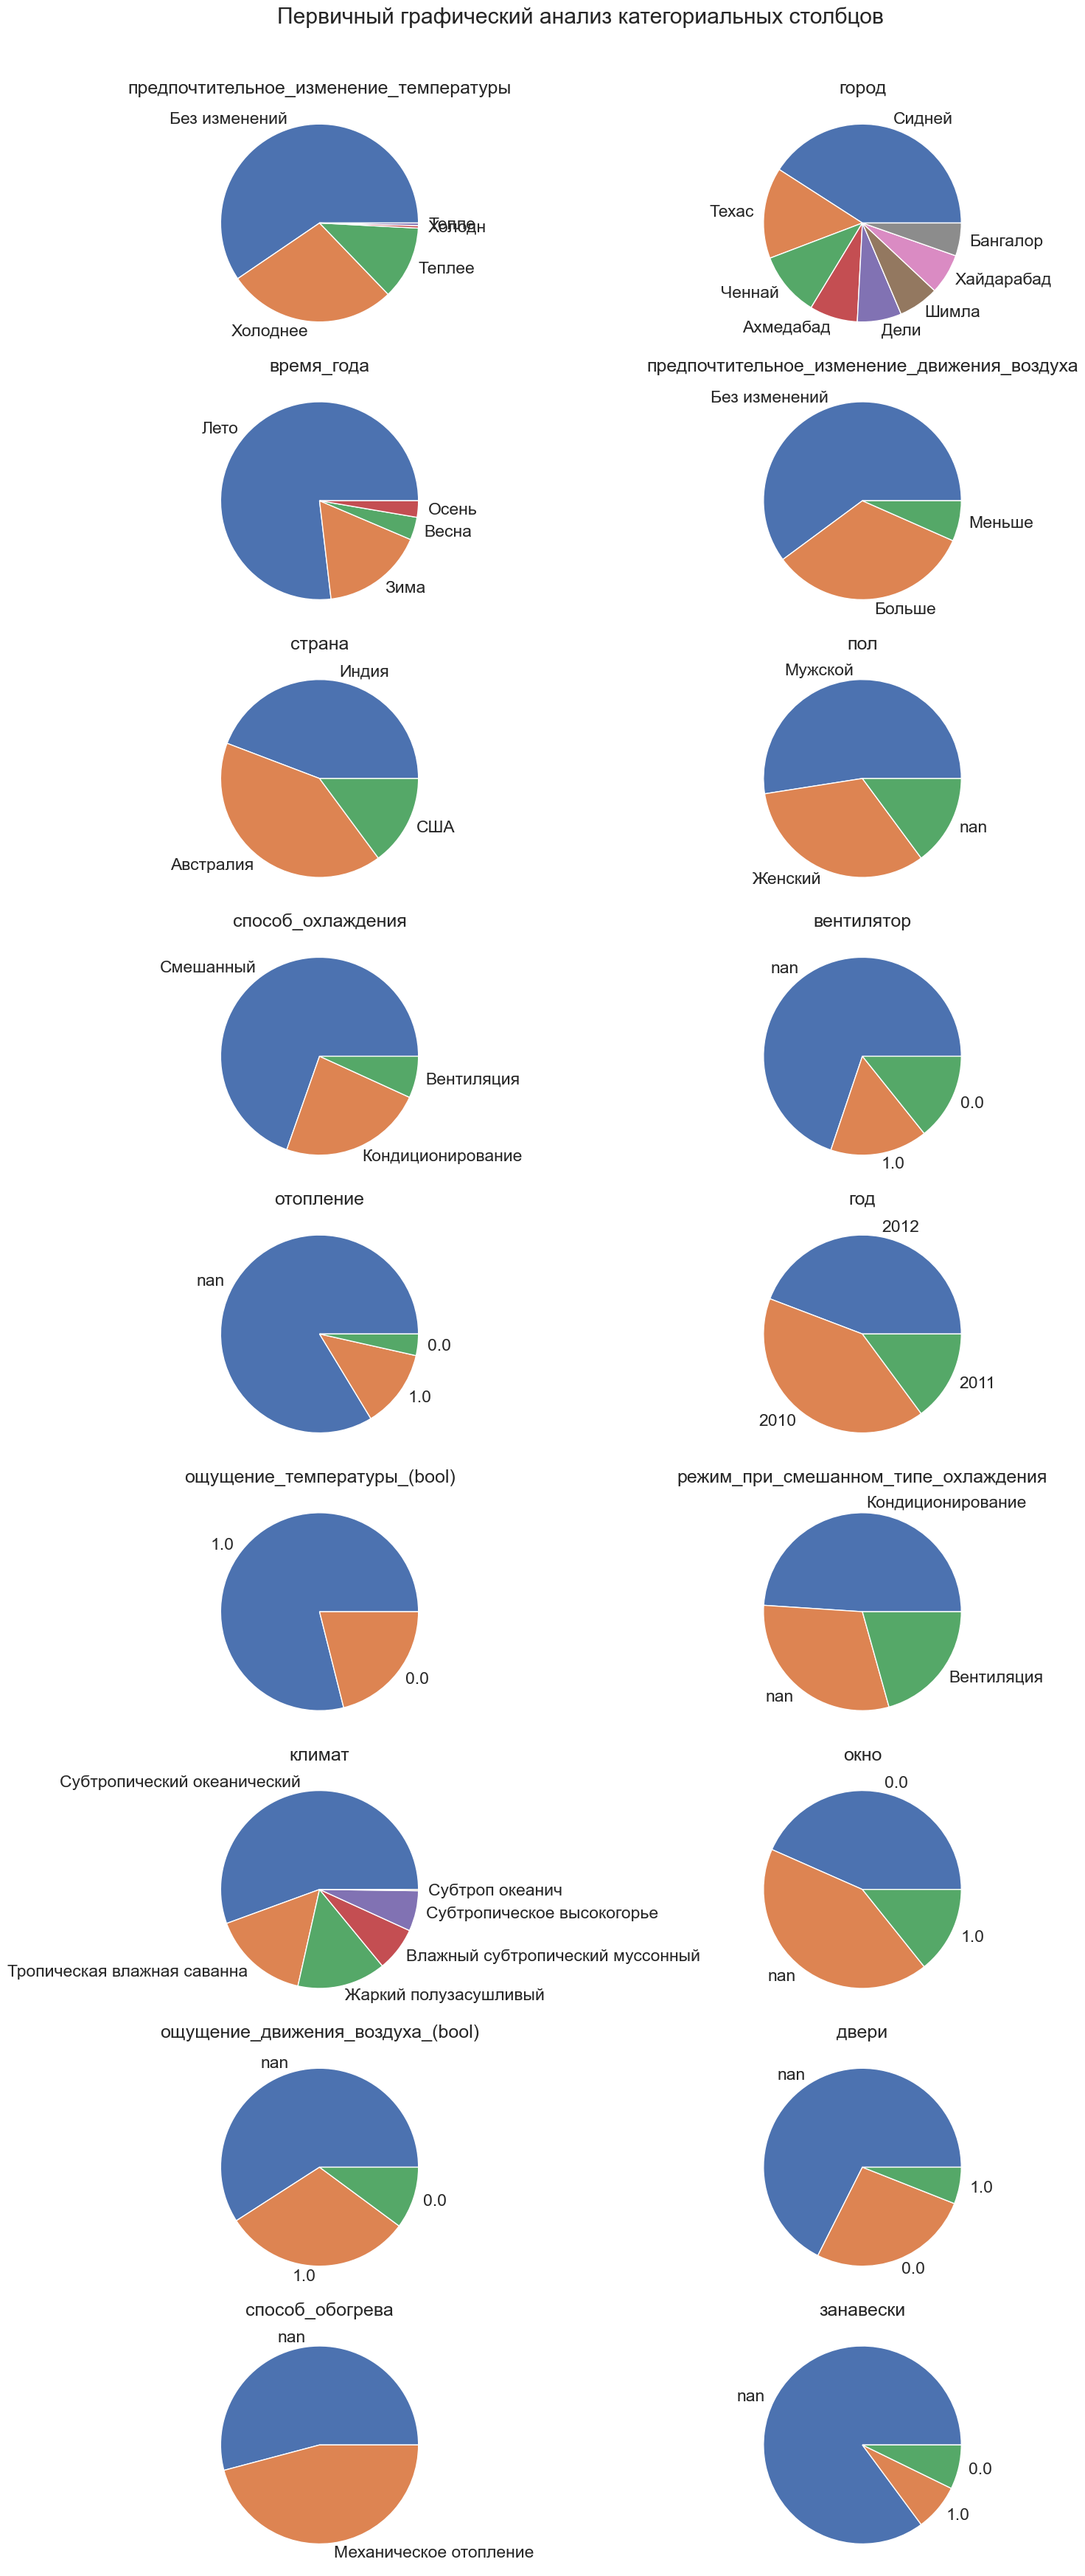

In [9]:
fig, ax = plt.subplots((len(categorial) + 1) // 2, 2)
fig.suptitle("Первичный графический анализ категориальных столбцов", y=1.01)
fig.set_figheight(35)
fig.set_figwidth(15)
fig.tight_layout(h_pad=0)
for i, col in enumerate(categorial):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[i // 2][i % 2].pie(value_counts, labels=value_counts.index)
    ax[i // 2][i % 2].set_title(col)

С помощью графиков выше легко выявить некоторые аномалии, которые встречаются в нашем датасете. Рассмотрим эти аномалии и проработаем их.

Обнаруженные аномалии:

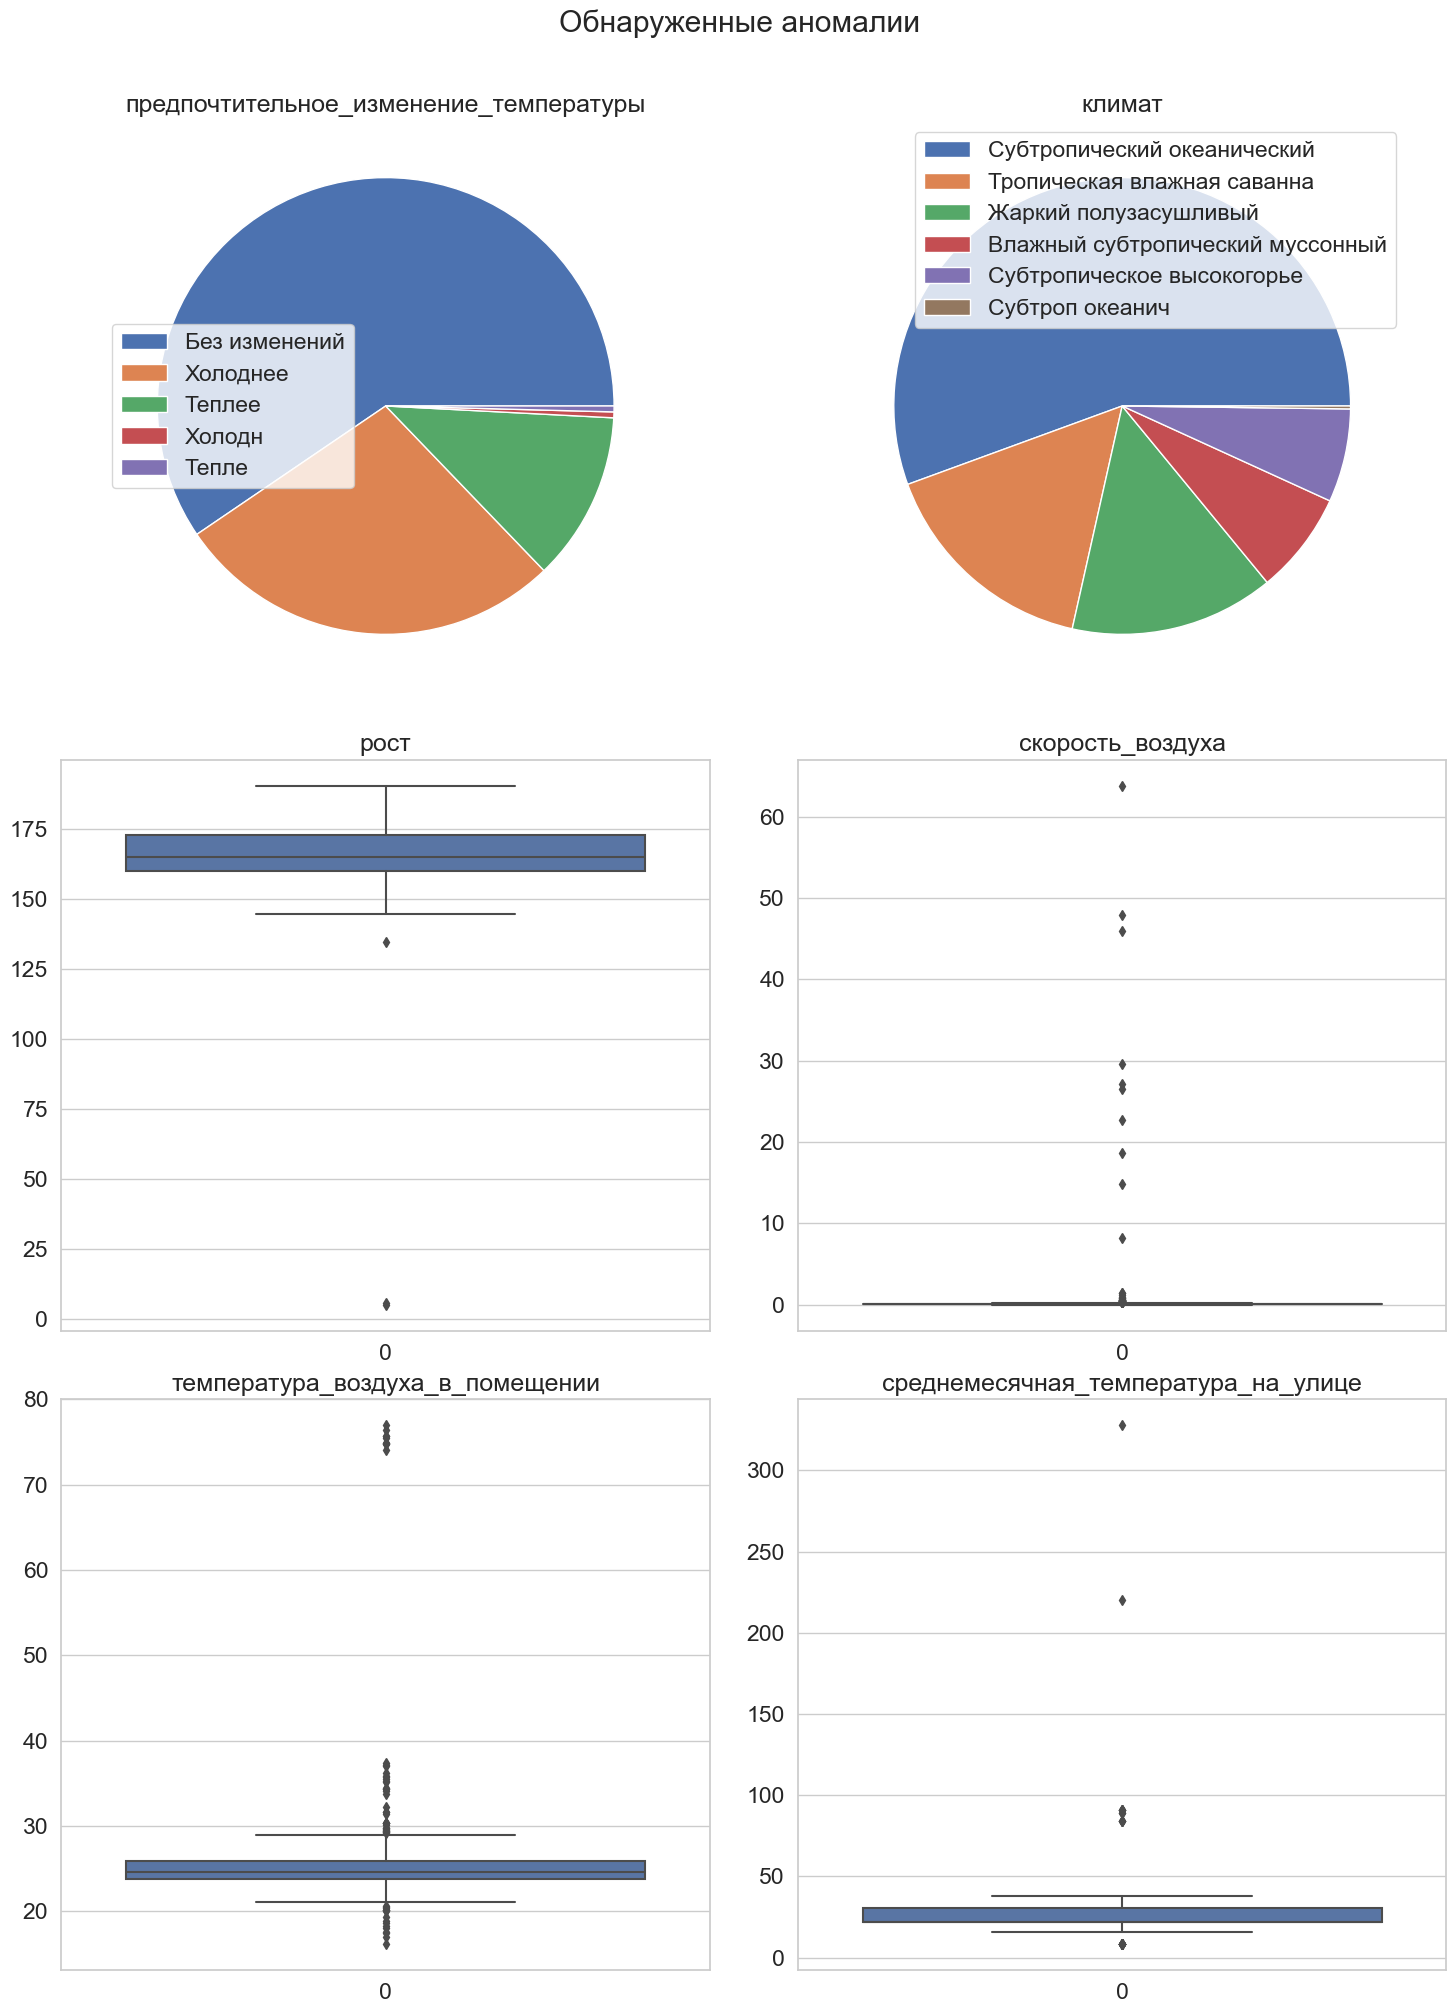

In [10]:
anomalies = ['предпочтительное_изменение_температуры', 'климат', 'рост', 'скорость_воздуха', 'температура_воздуха_в_помещении', 'среднемесячная_температура_на_улице']

fig, ax = plt.subplots((len(anomalies) + 1) // 2, 2)
fig.set_figheight(20)
fig.suptitle("Обнаруженные аномалии", y=1.01)
fig.set_figwidth(15)
fig.tight_layout()

for i, col in enumerate(anomalies):
    if col in numerical:
        sns.boxplot(df[col], ax=ax[i // 2][i % 2])
        ax[i // 2][i % 2].set_xlabel("")
        ax[i // 2][i % 2].set_title(col)
    else:
        patches, _ = ax[i // 2][i % 2].pie(pd.value_counts(df[col], dropna=False))
        ax[i // 2][i % 2].legend(patches, pd.value_counts(df[col], dropna=False).index)
        ax[i // 2][i % 2].set_title(col)

Так как фактор **"режим_при_смешанном_типе_охлаждения"** и **"способ_охлаждения"** имеют одинаковый смысл, то можно заменить **"смешанный"** в **"режим_при_смешанном_типе_охлаждения"** на **"Кондиционирование"** или **"Вентиляция"**.
Это может помочь нам в будущем во время обучения регрессионной модели.

In [11]:
def change_kind_of_cooling(row):
    if row['режим_при_смешанном_типе_охлаждения'] == 'Кондиционирование':
        return 'Кондиционирование'
    elif row['режим_при_смешанном_типе_охлаждения'] == 'Вентиляция':
        return 'Вентиляция'
    return row['способ_охлаждения']

df['способ_охлаждения'] = df.apply(change_kind_of_cooling, axis='columns')
df = df.drop('режим_при_смешанном_типе_охлаждения', axis=1)
categorial.remove('режим_при_смешанном_типе_охлаждения')

## Исправление орфографических ошибок

Обнаружены орфографические ошибки:
- В столбце **"предпочтительное_изменение_температуры"** *"Тепле"* и *"Холодн"*
- В столбце **"климат"** *"Субтроп океанич"*
- *"Техас"* в столбце **"город"** это ошибка, однако заменить мы это ничем не можем, так как городов в штате Техас много, но и избавляться от этих дынных не стоит, поэтому оставим как есть

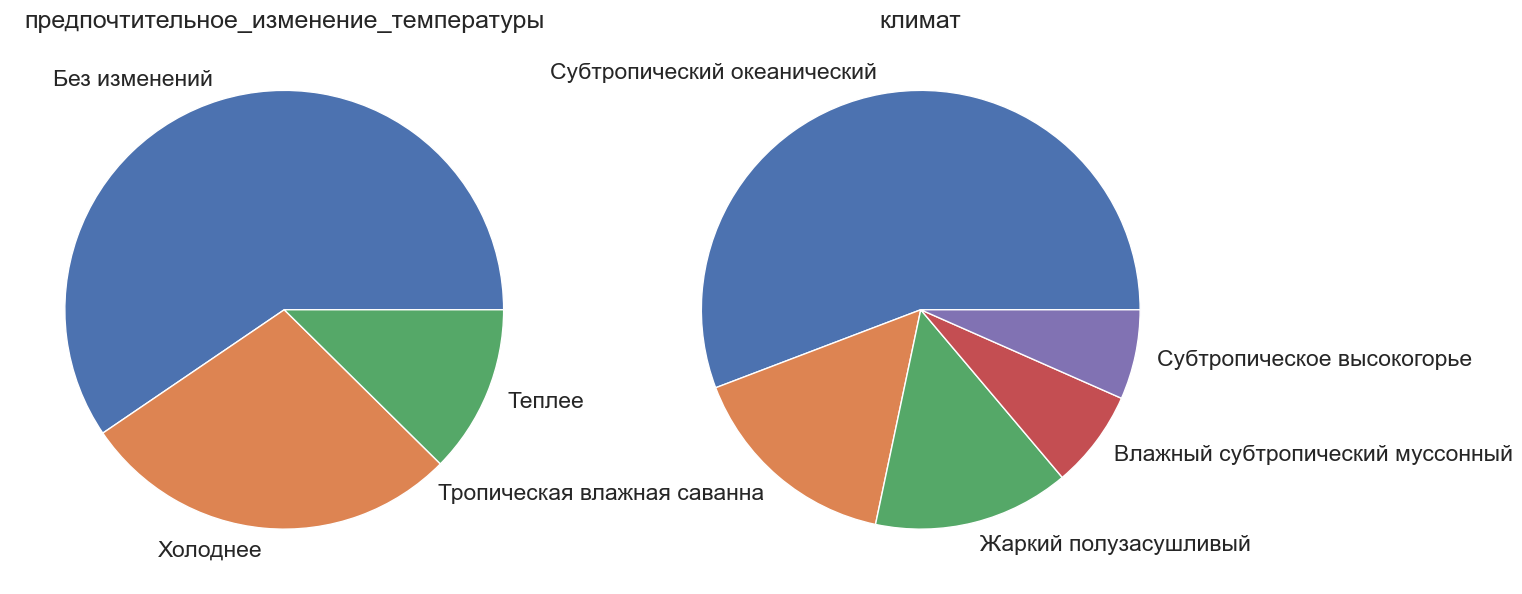

In [12]:
def fix_spelling_1st_problem(word: str) -> str:
    return "Теплее" if word == "Тепле" else "Холоднее" if word == "Холодн" else word
 
def fix_spelling_2nd_problem(word: str) -> str:
    return "Cубтропический океанический" if word == "Cубтроп океанич" else word

df["предпочтительное_изменение_температуры"] = df["предпочтительное_изменение_температуры"].apply(fix_spelling_1st_problem)
df["климат"] = df["климат"].apply(fix_spelling_2nd_problem)

# Проверка 

columns = ['предпочтительное_изменение_температуры', 'климат']

fig, ax = plt.subplots(1, 2)
fig.set_figheight(30)
fig.set_figwidth(13)
fig.tight_layout(h_pad=0)
for ind, col in enumerate(columns):
    value_counts = pd.value_counts(df[col], dropna=False)
    ax[ind].pie(value_counts, labels=value_counts.index)
    ax[ind].set_title(col)

## Исправление выбросов в росте

Рассмотрим данные о росте с помощью boxplot, чтобы найти выбросы:

Text(0.5, 1.0, 'рост')

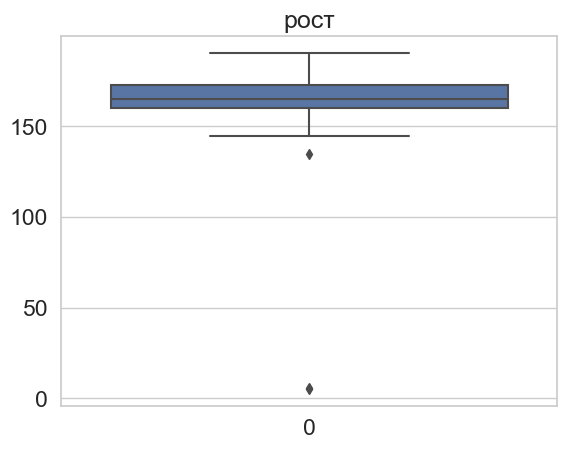

In [13]:
fig, ax = plt.subplots()
sns.boxplot(df['рост'], ax=ax)
ax.set_title("рост")

In [14]:
df[df['рост'] < 150]['рост']

287      5.23
301    147.30
306      5.74
325    144.80
340    134.60
Name: рост, dtype: float64

В росте имеются выбросы в меньшую сторону. Списать на ошибку при вводе нельзя.

Предположим, что респондент, указавший рост меньше 100, указал рост в футах:

In [15]:
df[df['рост'] < 100]['рост'] * 30.48

287    159.4104
306    174.9552
Name: рост, dtype: float64

Действительно, рост получился нормальным. Поэтому гипотеза подтвердилась.

Что делать с ростом меньшим чем 150 см? Посмотрим на личные данные респондента:

In [16]:
df[df['рост'].between(100, 150)][['рост', 'страна', 'пол', 'возраст', 'год']]

,рост,страна,пол,возраст,год
301,147.3,Индия,Женский,55.0,2012
325,144.8,Индия,Женский,25.0,2012
340,134.6,Индия,Женский,25.0,2012


Самый низкий зарегистрированный рост в Индии за 2011 год принадлежал Джоти Амге. Она была признана самой низкорослой женщиной в мире в возрасте 18 лет. Ее рост составлял [61,95 см](https://en.wikipedia.org/wiki/Jyoti_Amge). Поэтому предположим что рост меньше 140, который присутствует в наших данных не считается аномалией, к тому же наших данных и так мало.

Text(0.5, 1.0, 'рост')

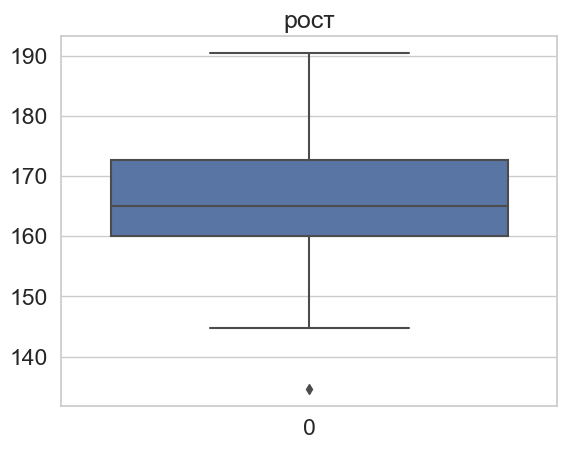

In [17]:
# Переводим дюймы в сантиметры
def fix_height(num: int) -> int:
    return num if num > 50 else num * 30.48

df['рост'] = df['рост'].apply(fix_height)

# Смотрим на рещзультат 
fig, ax = plt.subplots()
sns.boxplot(df['рост'], ax=ax)
ax.set_title("рост")

## Исправление выбросов в скорости воздуха

Скорость более 5 м/с **в помещении** считаем аномальной:

In [18]:
df[df['скорость_воздуха'] > 5]['скорость_воздуха']

3     27.16
4     63.83
10    18.65
26    46.00
28    47.97
31    29.61
53    26.49
59    22.68
65    14.85
70     8.20
Name: скорость_воздуха, dtype: float64

<Axes: xlabel='скорость_воздуха'>

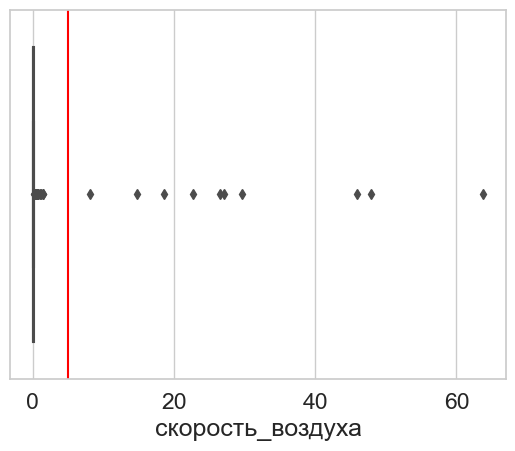

In [19]:
plt.axvline(x=5, color='red')

sns.boxplot(data=df, x='скорость_воздуха')

↑ Красная линия - граница *(x = 5)*: если значение больше 5, то это аномалия

Большинство аномальных скоростей - двузначные числа. Возможно респондент указал скорость не в **м/с**, а в **см/с**
<br>
Также скорости > 5, но < 10, можно рассматривать в сантиметрах, поскольку в датасете имеются скорости < 0.1 и это будет нормальной скоростью для воздуха в помещении.

<Axes: >

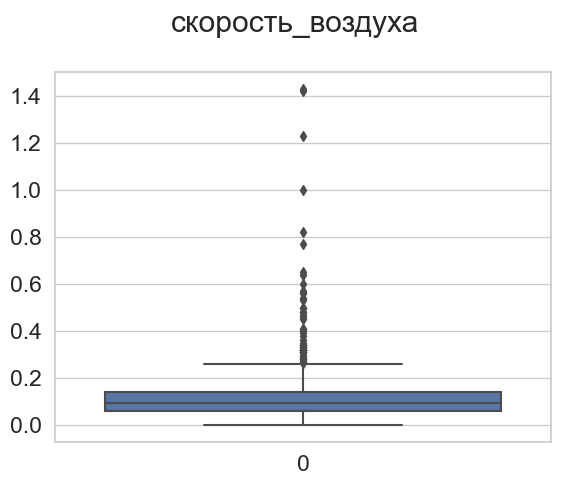

In [20]:
# заменяем все показания в колонке скорость воздуха больше 30 на None, ибо такие показатели аномальные
df['скорость_воздуха'] = df['скорость_воздуха'].apply(lambda x: x if x <= 5 else x / 100)

plt.suptitle("скорость_воздуха", y=1.01)
sns.boxplot(df['скорость_воздуха'])

## Исследование колонок с температурой

Исследуем аномалии используя boxplot:

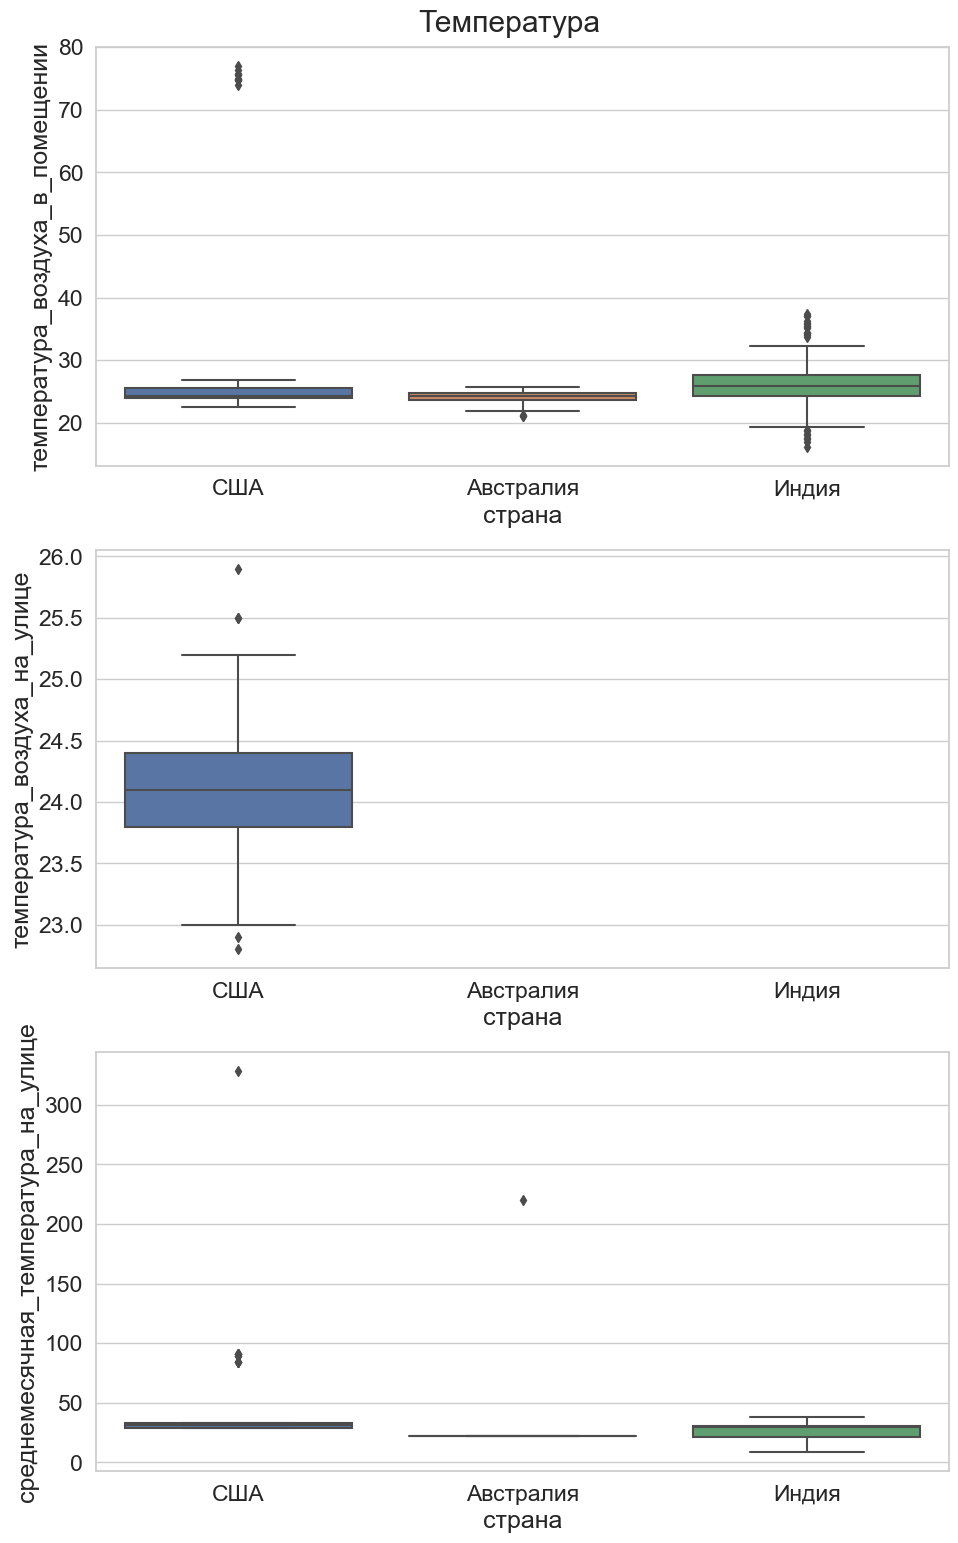

In [21]:
temperature_cols = [
    'температура_воздуха_в_помещении',
    'температура_воздуха_на_улице',
    'среднемесячная_температура_на_улице'
]
fig, ax = plt.subplots(3, 1)
fig.set_figwidth(11)
fig.set_figheight(18.5)
fig.suptitle("Температура", y=0.9)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

Заметим, что у США наблюдаются выбросы в большую сторону. Предположим, что температура указана в °F. Тогда конвертируем все значения больше 40 из °F в °C. 

<Axes: xlabel='страна', ylabel='среднемесячная_температура_на_улице'>

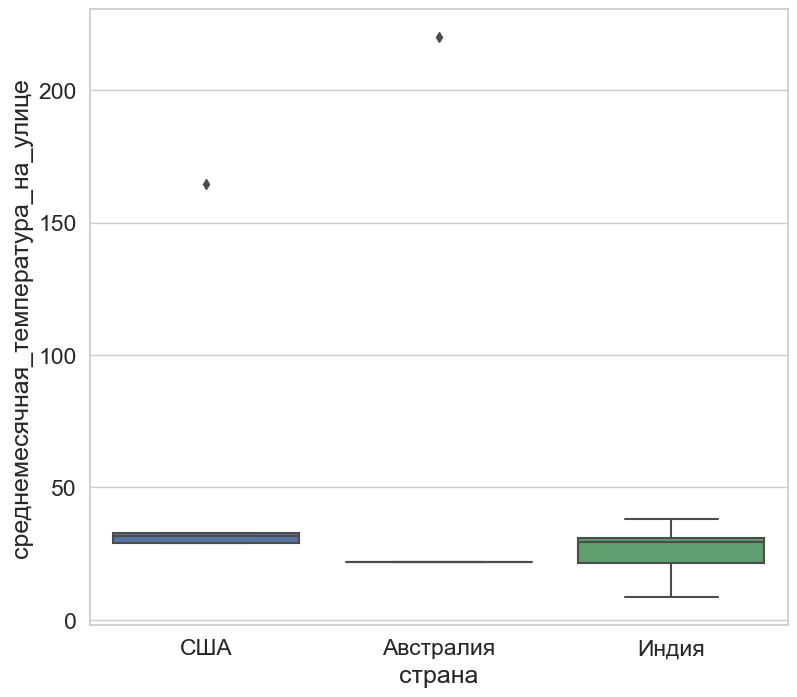

In [22]:
def f2c(row):
    # Фаренгейты в Цельсия (среднемесячная_температура_на_улице)
    if row.loc['среднемесячная_температура_на_улице'] is None:
        return None
    
    if row.loc['страна'] == 'США':
        if row.loc['среднемесячная_температура_на_улице'] > 40:
            return (row['среднемесячная_температура_на_улице']  - 32) * 5 / 9
    return row.loc['среднемесячная_температура_на_улице']

df_new1 = pd.DataFrame()
df_new1['страна'] = df['страна']
df_new1['время_года'] = df['время_года']
df_new1['среднемесячная_температура_на_улице'] = df.apply(f2c, axis=1)
fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(9)
sns.boxplot(data=df_new1, x='страна', y='среднемесячная_температура_на_улице', ax=ax)

<Axes: xlabel='страна', ylabel='температура_воздуха_в_помещении'>

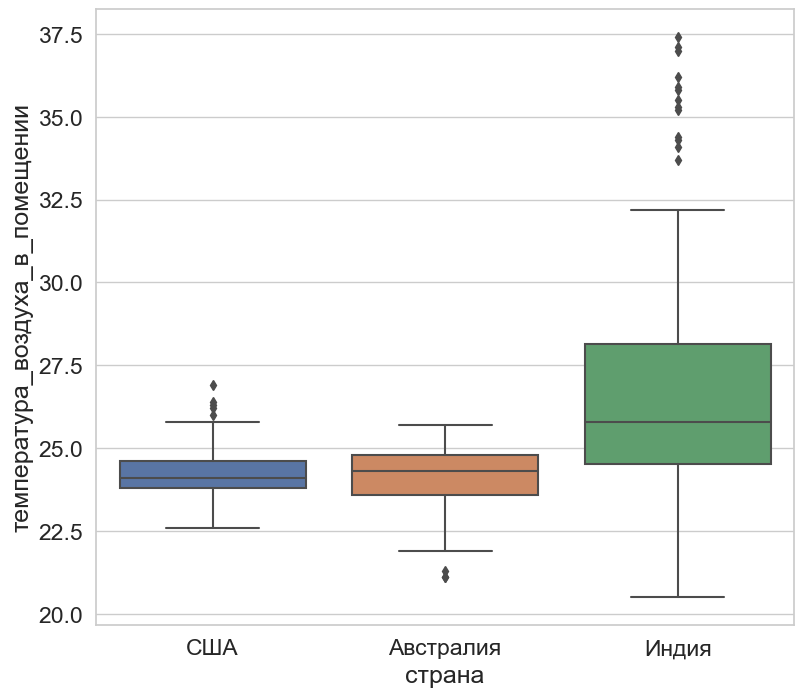

In [23]:
def f2c(row):
    # Фаренгейты в Цельсия (температура_воздуха_в_помещении)
    if row.loc['температура_воздуха_в_помещении'] is None:
        return None
    
    if row.loc['страна'] == 'США':
        if row.loc['температура_воздуха_в_помещении'] > 40:
            return (row['температура_воздуха_в_помещении']  - 32) * 5 / 9
    return row.loc['температура_воздуха_в_помещении']

df_new2 = pd.DataFrame()
df_new2['страна'] = df['страна']
df_new2['время_года'] = df['время_года']
df_new2['температура_воздуха_в_помещении'] = df.apply(f2c, axis=1)
fig, ax = plt.subplots(1, 1)
fig.set_figheight(8)
fig.set_figwidth(9)
sns.boxplot(data=df_new2[df_new2['время_года'] == 'Лето'], x='страна', y='температура_воздуха_в_помещении', ax=ax)

Аномальная температура после конвертации из Фаренгейтов не сильно выбивается из распределения, поэтому предположим, что наше допущение о фаренгейтах было верным.

In [24]:
df['температура_воздуха_в_помещении'] = df_new2['температура_воздуха_в_помещении']
df['среднемесячная_температура_на_улице'] = df_new1['среднемесячная_температура_на_улице']

Остальные аномальные значения, которые не удалось восстановить, удалим используя метод тройного интерквартильного размаха:

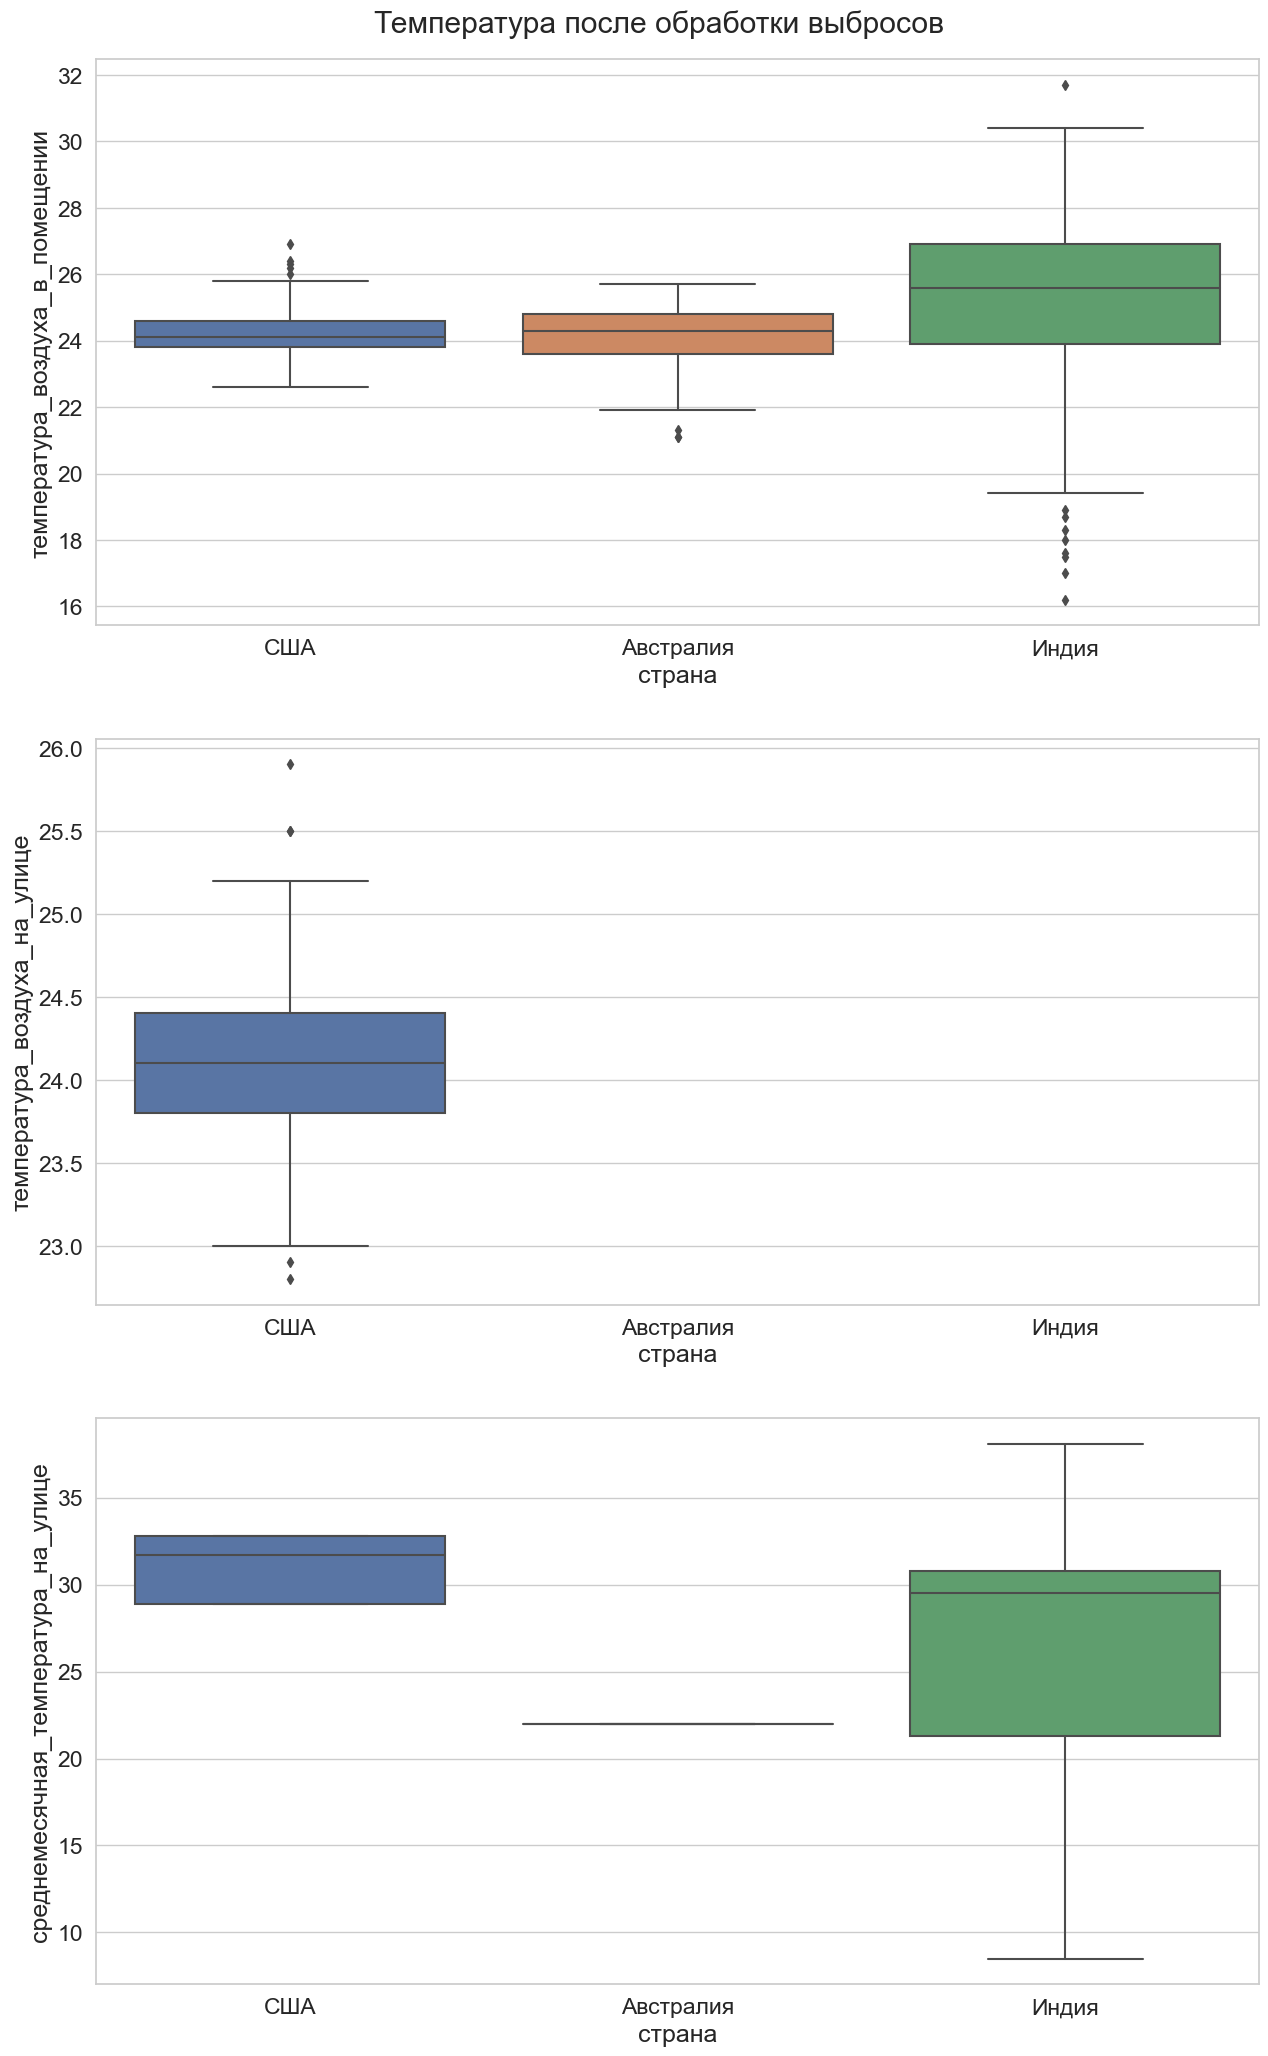

In [25]:
def change_temperature(row, c):
    season = ['Лето', 'Зима', 'Осень', 'Весна']
    season_idx = season.index(row[1])
    col_idx = list(row.index).index(c)
    if lower_bound[season_idx] <= row[col_idx] <= upper_bound[season_idx]:
        return row[col_idx]
    return None



for col in temperature_cols:
    Q1 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.25),
        df[df['время_года'] == 'Зима'][col].quantile(0.25),
        df[df['время_года'] == 'Осень'][col].quantile(0.25),
        df[df['время_года'] == 'Весна'][col].quantile(0.25),
    ]
    Q3 = [
        df[df['время_года'] == 'Лето'][col].quantile(0.75),
        df[df['время_года'] == 'Зима'][col].quantile(0.75),
        df[df['время_года'] == 'Осень'][col].quantile(0.75),
        df[df['время_года'] == 'Весна'][col].quantile(0.75),
    ]
    IQR = [
        Q3[0] - Q1[0],
        Q3[1] - Q1[1],
        Q3[2] - Q1[2],
        Q3[3] - Q1[3],
    ]
    lower_bound = [
        Q1[0] - 3 * IQR[0],
        Q1[1] - 3 * IQR[1],
        Q1[2] - 3 * IQR[2],
        Q1[3] - 3 * IQR[3]
    ]
    upper_bound = [
        Q3[0] + 3 * IQR[0],
        Q3[1] + 3 * IQR[1],
        Q3[2] + 3 * IQR[2],
        Q3[3] + 3 * IQR[3],
    ]
    df[col] = df.apply(change_temperature, axis=1, c=col)

fig, ax = plt.subplots(3, 1)
fig.suptitle("Температура после обработки выбросов", y=0.9)
fig.set_figwidth(15)
fig.set_figheight(25)
for i, col in enumerate(temperature_cols):
    sns.boxplot(data=df, x='страна', y=col, ax=ax[i])

In [26]:
# Значения < 15°C в Индии нельзя считать выбросами, так как они были замеренны зимой, проверка:
df[(df['страна'] == 'Индия') & (df['среднемесячная_температура_на_улице'] < 15)]['время_года'].value_counts()

время_года
Зима    14
Name: count, dtype: int64

## Обработка дубликатов (удаляем)

In [27]:
print(df.duplicated().value_counts())
df = df.drop_duplicates()

False    482
True       2
Name: count, dtype: int64


## Заполнение пропусков
Числовые пропуски заполняем сейчас, поскольку их довольно мало. Категориальные пропуски не трогаем до тех пор, пока не начнем с ними работать.

<Axes: xlabel='Пропуски', ylabel='Столбцы'>

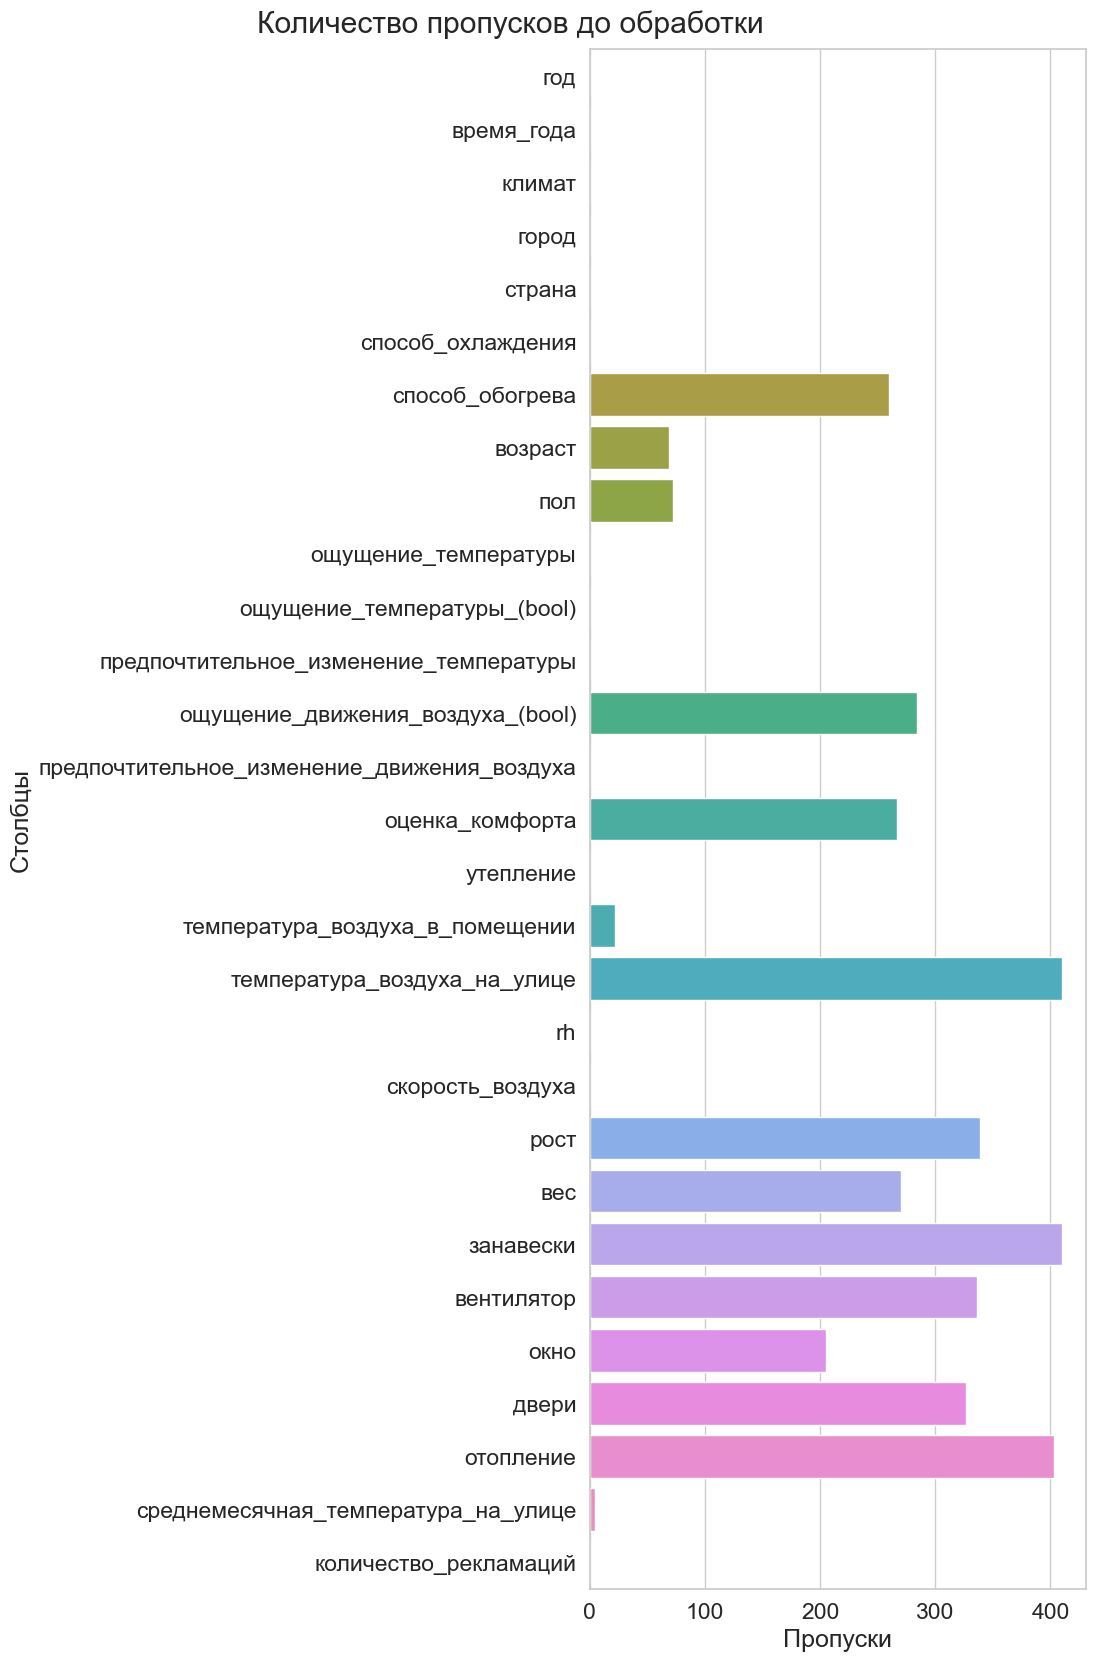

In [28]:
temp_dict = {"Столбцы": [], "Пропуски": []}

temp_df = df.copy().isna()
for col in temp_df.columns:
    temp_dict["Столбцы"].append(col)
    temp_dict["Пропуски"].append(temp_df[col].sum())
fig, ax = plt.subplots(1, 1)
fig.set_figheight(20)
fig.suptitle("Количество пропусков до обработки", y=0.9, x=0.001)
sns.barplot(pd.DataFrame(temp_dict), x='Пропуски', y='Столбцы', ax=ax)

Из всех столбцов имеет смысл заполнять только **возраст**, **температуру воздуха в помещении** и **температуру воздуха на улице**. Поскольку большая часть данных в этих столбцах присутствует и эти столбцы номинальные. 

#### Возраст

In [29]:
countries = df.groupby('страна')

In [30]:
# Заполняем, ориентируясь на медианное значение для каждой страны
def fillna_age(row):
    if pd.isnull(row.loc['возраст']):
        return age_median[row.loc['страна']]
    return row.loc['возраст']


age_median = countries['возраст'].median()
df['возраст'] = df.apply(fillna_age, axis=1)

#### Температура воздуха в помещении

In [31]:
# Заполняем, ориентируясь на медианное значение для каждого года, времени года и города
groups = df.groupby(['год', 'время_года', 'город'])['температура_воздуха_в_помещении'].median()

def fix_skips_temp_inside(row):
    if pd.isna(row['температура_воздуха_в_помещении']):
        return groups[row['год'], row['время_года'], row['город']]
    return row['температура_воздуха_в_помещении']

df['температура_воздуха_в_помещении'] = df.apply(fix_skips_temp_inside, axis=1)

#### Среднемесячная температура на улице

In [32]:
temperature_groups = df.groupby(['город', 'год', 'время_года'])['среднемесячная_температура_на_улице'].median()
print(temperature_groups)

temperature_groups['Хайдарабад', 2012, 'Осень'] = (
    temperature_groups['Хайдарабад', 2012, 'Лето'] + temperature_groups['Хайдарабад', 2012, 'Зима']
) / 2

город       год   время_года
Ахмедабад   2012  Зима          21.3
                  Лето          29.5
Бангалор    2012  Зима          29.9
                  Лето          30.8
Дели        2012  Зима          15.5
                  Лето          30.9
Сидней      2010  Лето          22.0
Техас       2011  Лето          31.7
Хайдарабад  2012  Весна         31.5
                  Зима          21.6
                  Лето          27.0
                  Осень          NaN
Ченнай      2012  Весна         30.4
                  Зима          30.8
                  Лето          38.1
                  Осень         29.7
Шимла       2012  Зима           8.5
                  Лето          18.5
Name: среднемесячная_температура_на_улице, dtype: float64


In [33]:
# Заполняем среднемесячную температуру ориентируясь на город, год и время года

def fillna_age(row):
    if pd.isnull(row['среднемесячная_температура_на_улице']):
        return temperature_groups[row['город'], row['год'], row['время_года']]
    return row['среднемесячная_температура_на_улице']


df['среднемесячная_температура_на_улице'] = df.apply(fillna_age, axis=1)

Ещё раз посмотрим на пропуски в наших данных после заполнения:

<Axes: xlabel='Пропуски', ylabel='Столбцы'>

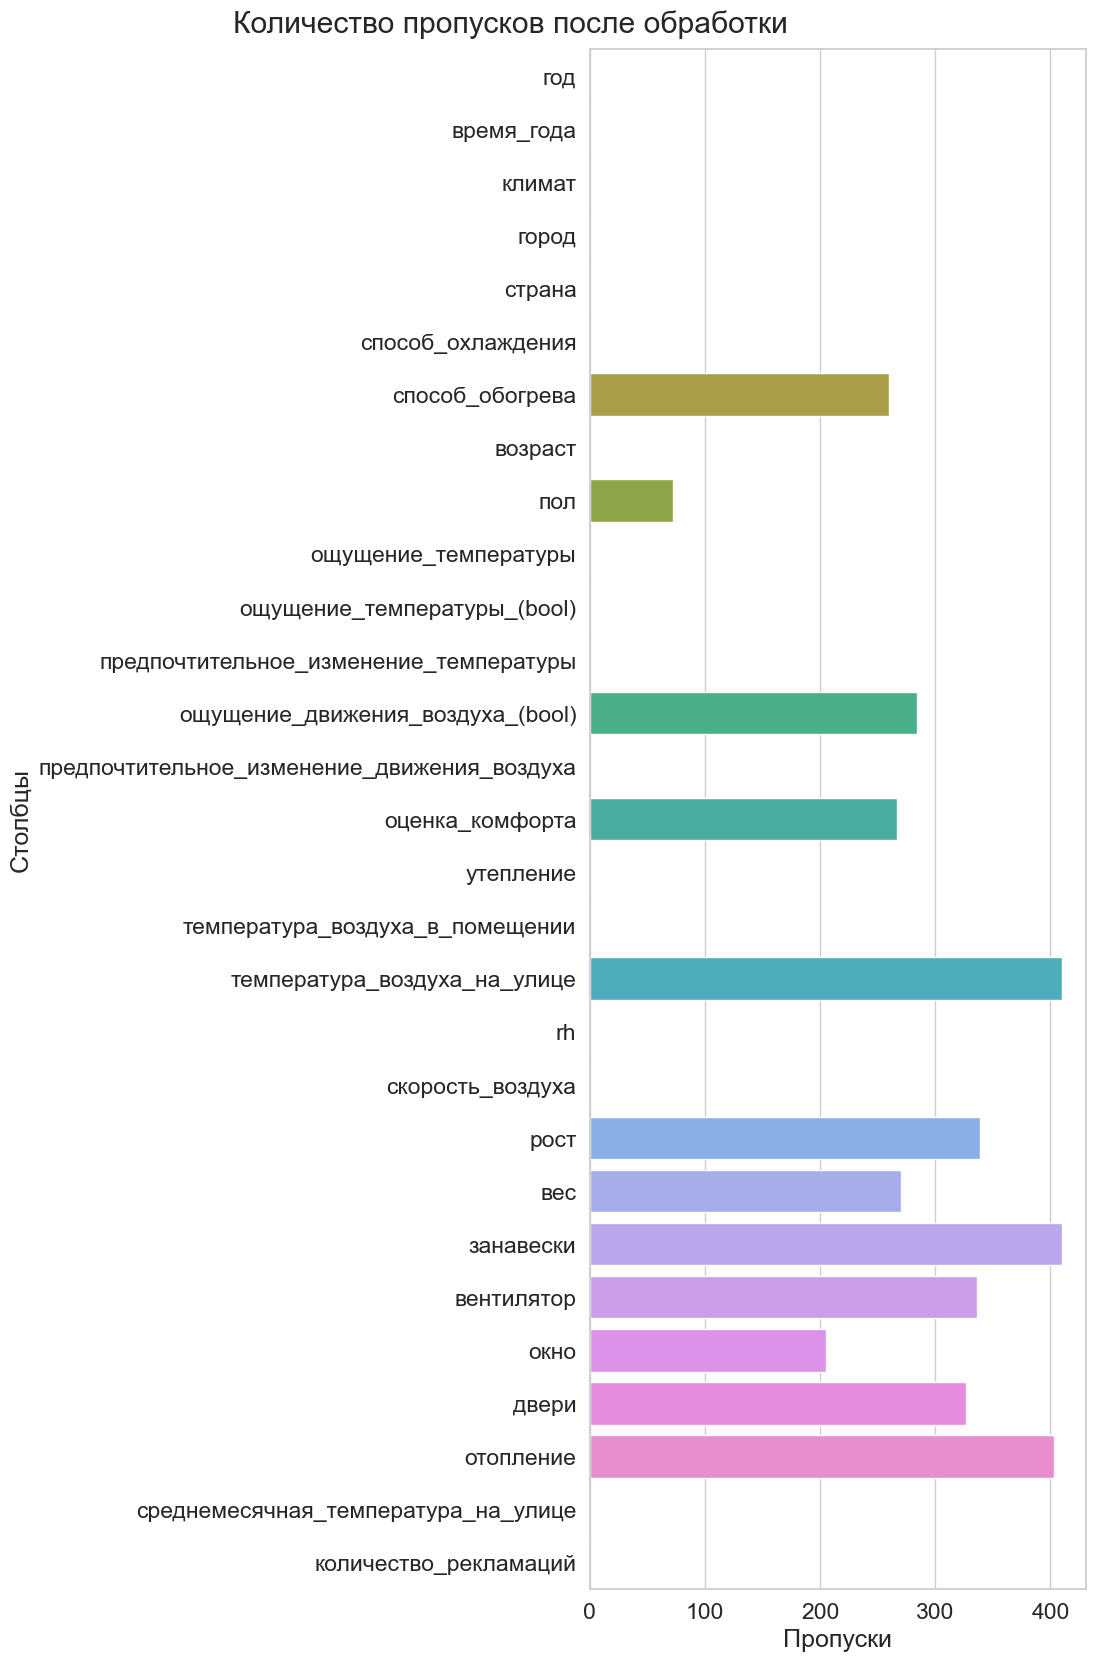

In [34]:
temp_dict = {"Столбцы": [], "Пропуски": []}

temp_df = df.copy().isna()
for col in temp_df.columns:
    temp_dict["Столбцы"].append(col)
    temp_dict["Пропуски"].append(temp_df[col].sum())
fig, ax = plt.subplots(1, 1)
fig.set_figheight(20)
fig.suptitle("Количество пропусков после обработки", y=0.9, x=0.001)
sns.barplot(pd.DataFrame(temp_dict), x='Пропуски', y='Столбцы', ax=ax)

# Проведение расчётов и исследований

## Создание категориального стоблца кол-ва рекламаций

<Axes: ylabel='count'>

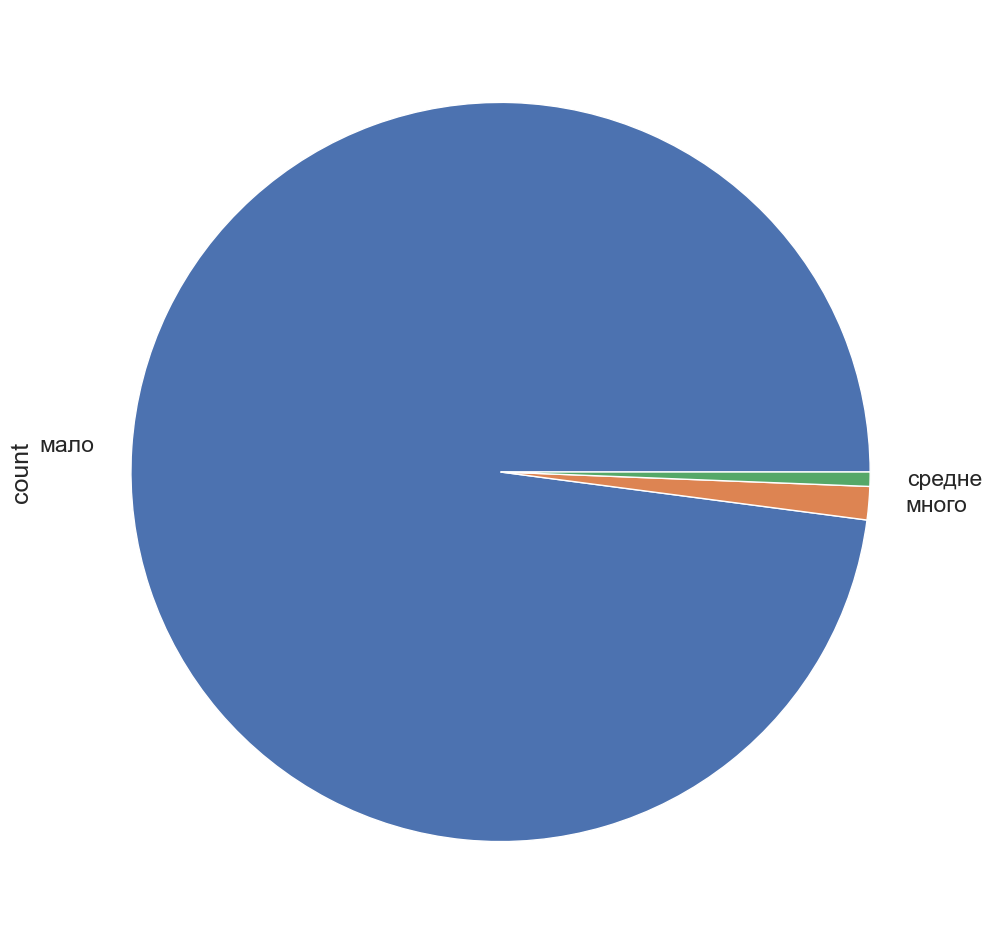

In [35]:
df['количество_рекламаций_кат'] = ['мало' if i <= 1 else ('средне' if i == 2 else 'много') for i in df['количество_рекламаций']]
plt.figure(figsize=(12, 12))
df['количество_рекламаций_кат'].value_counts().plot.pie()

Подавляющее большинство респондентов имеют не более 1-ой рекламации.

## Создание категориального столбца по возрастным группам

<Axes: ylabel='count'>

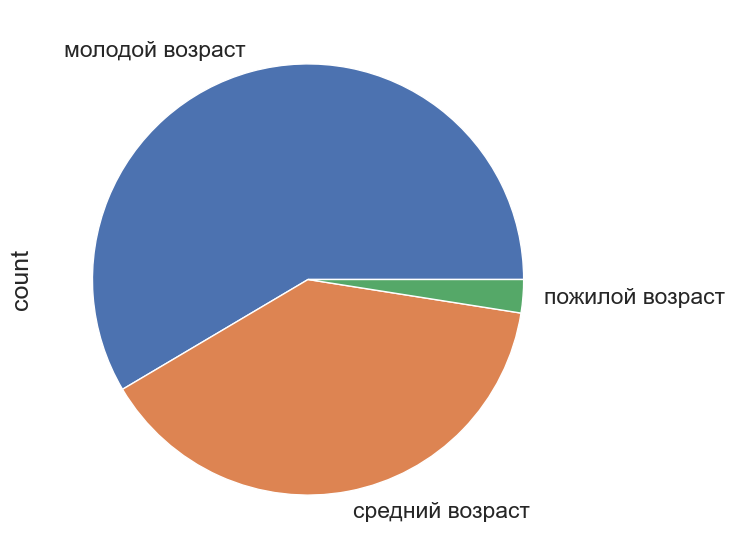

In [36]:
df['возрастная_группа'] = ['молодой возраст' if i <= 44 else ('средний возраст' if 45 <= i <= 59 else 'пожилой возраст') for i in df['возраст']]
plt.figure(figsize=(7,7))
df['возрастная_группа'].value_counts().plot.pie()

## Расчёт средней комфортной температуры в зависимости от возрастной категории

In [37]:
df[df['ощущение_температуры_(bool)'] == 1].groupby(['возрастная_группа'])['температура_воздуха_в_помещении'].mean().round(2)

возрастная_группа
молодой возраст    24.87
пожилой возраст    25.40
средний возраст    23.94
Name: температура_воздуха_в_помещении, dtype: float64

Сложно сказать отличается ли средняя комфортная температура для разных возрастных групп. Погрешность в 1-2 градуса можно объяснить маленьким количеством данных и малой долей группы людей пожилого возраста. Эту гипотезу мы рассмотрим в начале следующей главы.

## Средний возраст респондентов по полу и стране

По полу:

In [38]:
df.groupby('пол')['возраст'].mean()

пол
Женский    41.923077
Мужской    39.566929
Name: возраст, dtype: float64


По стране:

In [39]:
print(df.groupby('страна')['возраст'].mean())

страна
Австралия    44.292929
Индия        36.886792
США          36.208333
Name: возраст, dtype: float64


In [40]:
print(df.groupby(['страна', 'пол'])['возраст'].mean())

страна     пол    
Австралия  Женский    46.348315
           Мужской    42.614679
Индия      Женский    36.044776
           Мужской    37.275862
Name: возраст, dtype: float64


## Медианное значение влажности и температуры для каждого типа охлаждения

In [41]:
df.groupby('способ_охлаждения')[['температура_воздуха_в_помещении', 'rh']].median()

,температура_воздуха_в_помещении,rh
способ_охлаждения,,
Вентиляция,23.95,53.5
Кондиционирование,24.60,54.1


## Сводная таблица с данными, сгруппированными по стране, полу, возрастной группе

In [42]:
print(df.groupby(['страна', 'пол', 'возрастная_группа'])[['температура_воздуха_в_помещении', 'температура_воздуха_на_улице', 'rh']].mean())

                                     температура_воздуха_в_помещении  \
страна    пол     возрастная_группа                                    
Австралия Женский молодой возраст                          23.840000   
                  пожилой возраст                          24.900000   
                  средний возраст                          24.112500   
          Мужской молодой возраст                          24.146667   
                  пожилой возраст                          24.733333   
                  средний возраст                          24.044262   
Индия     Женский молодой возраст                          25.820192   
                  средний возраст                          23.110000   
          Мужской молодой возраст                          25.685500   
                  пожилой возраст                          29.300000   
                  средний возраст                          24.002273   

                                     температура_воздуха_на_ули

## Стандартная комфортная относительная влажность в помещениях
- Согласно [СанПиН 2.2.4.548—96](https://kpfu.ru/portal/docs/F_979595184/SanPiN.2.2.4.548_96.o.mikroklimate.pdf) оптимальная влажность в рабочих помещениях в теплое и холодное время года должна составлять от $40\% - 60 \%$.
- Однако, согласно Управлению по охране труда США (Occupational Safety and Health Administration, OSHA) оптимальная влажность должна лежать в диапазоне от $20\% - 60\%$. [Ссылка на положение](https://www.osha.gov/laws-regs/standardinterpretations/2003-02-24).

Тем не менее, диапазон от $40$ до $60$ является более щадящим, что подтверждается приведенной ниже диаграммой. Поэтому в рамках нашего исследования мы будем опираться на него.
![](https://cndarcdn.scdn3.secure.raxcdn.com/m/0/diagramma-scofild-sterling-rus-01-1.jpg) [Страница с исследованиями в защиту диапазона от 40 до 60](https://40to60rh.com/)

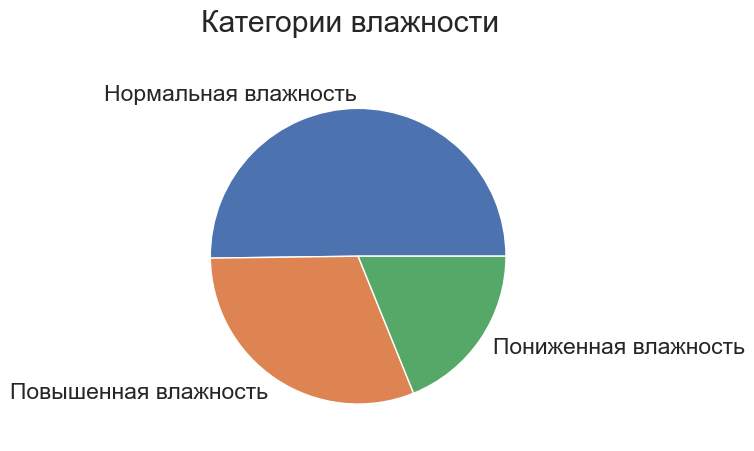

In [43]:
def rh2cat(rh):
    if 40 <= rh <= 60:
        return "Нормальная влажность"
    if rh < 40:
        return "Пониженная влажность"
    return "Повышенная влажность"

df['rh_кат'] = df['rh'].apply(rh2cat)
pd.value_counts(df['rh_кат']).plot.pie()

plt.suptitle("Категории влажности", y=1.01)
plt.ylabel("")
plt.show()

Интересно, что только у половины респондентов **нормальная** влажность. Влияние влажности на оценку комфорта респондента мы определим в следующей главе.

In [44]:
# Новые категориальные факторы
categorial.extend(['возрастная_группа', 'количество_рекламаций_кат', 'rh_кат'])

## Корреляция между параметрами

In [45]:

# Рассматриваем cущественные корреляции Номинальная-Номинальная

for col1, col2 in itertools.product(list(df.columns), repeat=2):
    if col1 in categorial and col2 in categorial:
        if col1 == col2:
            continue

        table = pd.crosstab(df[col1], df[col2])
        if len(table) == 0:
            continue
        
        res = stats.chi2_contingency(table)
        if res[1] < 0.05:
            n = table.sum().sum()
            phi2 = res[0] / n
            kramer = np.sqrt(phi2 / (min(table.shape) - 1))
            if kramer > 0.5:
                print(col1, col2, "  K=", kramer, "  p=", res[1])

год климат   K= 0.7071067811865476   p= 5.109130746665515e-99
год город   K= 1.0   p= 8.249698737851307e-197
год страна   K= 0.9999999999999999   p= 2.259471425529061e-207
климат год   K= 0.7071067811865476   p= 5.109130746665515e-99
климат город   K= 1.0   p= 0.0
климат страна   K= 0.7071067811865475   p= 5.109130746665662e-99
город год   K= 0.9999999999999999   p= 8.249698737852247e-197
город климат   K= 1.0   p= 0.0
город страна   K= 0.9999999999999999   p= 8.249698737852247e-197
страна год   K= 1.0   p= 2.2594714255288033e-207
страна климат   K= 0.7071067811865475   p= 5.109130746665662e-99
страна город   K= 0.9999999999999999   p= 8.249698737852245e-197
способ_охлаждения отопление   K= 0.8852745960730183   p= 3.589394311695889e-15
ощущение_температуры_(bool) предпочтительное_изменение_температуры   K= 0.5206045559803226   p= 4.2928622573762964e-29
ощущение_температуры_(bool) ощущение_движения_воздуха_(bool)   K= 0.6167399054321971   p= 4.017292262600697e-18
предпочтительное_измене

- корреляции год - <что-то> являются особенностью данных (за 2010 собраны данные за один город, за 2011 за другой)
- климат - год, климат - страна: корреляции очевидны (города не перемещаются из одной климатической зоны в другую, по крайней мере в рамках наших данных)
- город - способ_охлаждения: эти данные нам также ничего не дают
- страна - <что-то>: особенности данных
- способ_охлаждение - отопление: это не имеет смысла, поскольку корреляция не видна графическим методом и данные содержат много пропусков. Если эти пропуски убрать, то pvalue значительно поднимется
- ощущение_движения_воздуха_(bool) - ощущение_температуры_(bool): видимо если людям нравится как двигается воздух, то им нравится температура
- ощущение_движения_воздуха_(bool) - предпочтительное_изменение_температуры: если людям нравится как движется воздух, то они не хотят менять температуру?
- занавески - вентилятор: наличие занавесок говорит нам о наличии вентрилятора у человека

In [46]:
# Рассматриваем cущественные корреляции Количественная-Номаинальная 
temp_df = df.copy()
temp_df['способ_обогрева'] = temp_df['способ_обогрева'].fillna('нет')


for col1, col2 in itertools.product(list(categorial), list(numerical), repeat=1):
    if col1 == col2:
        continue
        
    if len(temp_df[col1].unique()) <= 2:
        g1 = temp_df[temp_df[col1] == temp_df[col1].unique()[0]][col2]
        g2 = temp_df[temp_df[col1] == temp_df[col1].unique()[1]][col2]

        if stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05:
            # применяем метод Стьюдента
            res = stats.ttest_ind(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Стьюдента')
        else:
            # применяем метод Манна-Уитни
            res = stats.mannwhitneyu(g1, g2)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Манна-Уитни')
    else:
        groups = []
        for i in temp_df[col1].unique():
            groups.append(temp_df[temp_df[col1] == i][col2])

        flag_normal = True
        for g in groups:
            if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
                # ненормальное распределение
                # применяем метод Краскела-Уоллиса
                flag_normal = False
                break

        if flag_normal:
            # применяем метод ANOVA
            res = stats.f_oneway(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'ANOVA')
        else:
            # применяем метод Краскела-Уоллиса
            groups = []
            for i in temp_df[col1].unique():
                groups.append(temp_df[temp_df[col1] == i][col2])
    
            res = stats.kruskal(*groups)
            if res[1] < 0.05:
                print(col1, col2, "  p=", res[1], 'Краскела-Уоллиса')

предпочтительное_изменение_температуры температура_воздуха_в_помещении   p= 0.0009320226619806667 Краскела-Уоллиса
предпочтительное_изменение_температуры скорость_воздуха   p= 0.0022108898629816854 Краскела-Уоллиса
предпочтительное_изменение_температуры среднемесячная_температура_на_улице   p= 6.029177238270281e-05 Краскела-Уоллиса
предпочтительное_изменение_температуры количество_рекламаций   p= 1.1041850623825452e-05 Краскела-Уоллиса
предпочтительное_изменение_температуры утепление   p= 0.004958305711016792 Краскела-Уоллиса
предпочтительное_изменение_температуры ощущение_температуры   p= 2.7720948513990012e-18 Краскела-Уоллиса
город возраст   p= 3.8975806745056604e-17 Краскела-Уоллиса
город температура_воздуха_в_помещении   p= 1.0946031973906458e-42 Краскела-Уоллиса
город rh   p= 1.931877046330633e-40 Краскела-Уоллиса
город скорость_воздуха   p= 2.753227156483443e-23 Краскела-Уоллиса
город среднемесячная_температура_на_улице   p= 1.1663093982364158e-63 Краскела-Уоллиса
город количест

C:\Programs\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1879: UserWarning: Input data for shapiro has range zero. The results may not be accurate.
  warnings.warn("Input data for shapiro has range zero. The results "


In [47]:
# Рассматриваем cущественные корреляции Количественная-Количественная

for col1, col2 in itertools.product(list(numerical), list(numerical), repeat=1):
    if col1 == col2:
        continue
    
    temp_df = df[[col1, col2]].copy().dropna()

    if (len(temp_df[col1]) > 3 and len(temp_df[col2] > 3)) and stats.shapiro(temp_df[col1])[1] > 0.05 and stats.shapiro(temp_df[col2])[1] > 0.05:
        # применяем метод Пирсона
        res = stats.pearsonr(temp_df[col1], temp_df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0], 'Пирсона')
    else:
        # применяем метод Спирмена
        res = stats.spearmanr(temp_df[col1], temp_df[col2])
        if res[1] < 0.05 and abs(res[0]) > 0.3:
            print(col1, col2, "  p=", res[1], " r=", res[0], 'Спирмена')

возраст среднемесячная_температура_на_улице   p= 1.666805780487155e-11  r= -0.30033274017068673 Спирмена
температура_воздуха_в_помещении температура_воздуха_на_улице   p= 1.2040906309557242e-16  r= 0.7919076449732448 Спирмена
температура_воздуха_в_помещении среднемесячная_температура_на_улице   p= 9.646282301215535e-14  r= 0.330426347653001 Спирмена
температура_воздуха_на_улице температура_воздуха_в_помещении   p= 1.2040906309557415e-16  r= 0.7919076449732447 Спирмена
температура_воздуха_на_улице rh   p= 0.0003220180302585918  r= -0.4121090281110435 Спирмена
температура_воздуха_на_улице среднемесячная_температура_на_улице   p= 9.740116390054459e-08  r= 0.5793161115091718 Спирмена
rh температура_воздуха_на_улице   p= 0.0003220180302585918  r= -0.4121090281110435 Спирмена
rh утепление   p= 1.1000607794607387e-19  r= -0.39739736393884445 Спирмена
скорость_воздуха среднемесячная_температура_на_улице   p= 4.4145349366139035e-34  r= 0.515537079742691 Спирмена
рост вес   p= 1.4292160202430308

<Axes: >

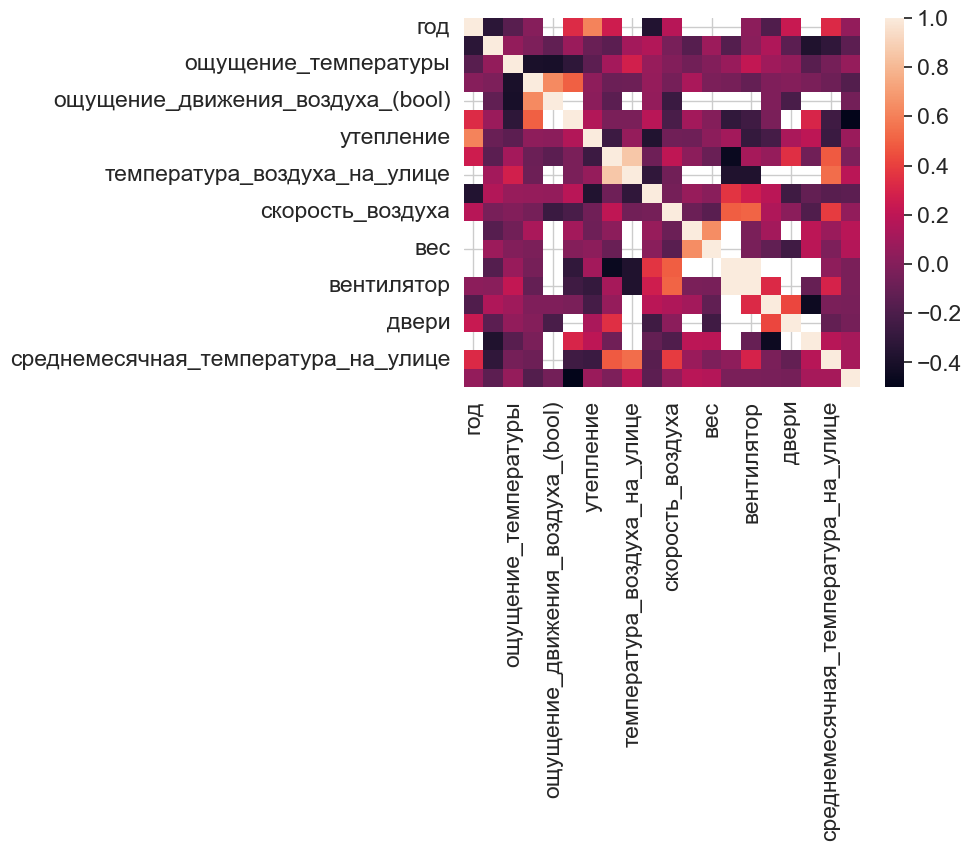

In [48]:
sns.heatmap(df.corr(numeric_only=True))

Визуализация некоторых значимых/интересных корреляций:

<Axes: xlabel='температура_воздуха_в_помещении', ylabel='среднемесячная_температура_на_улице'>

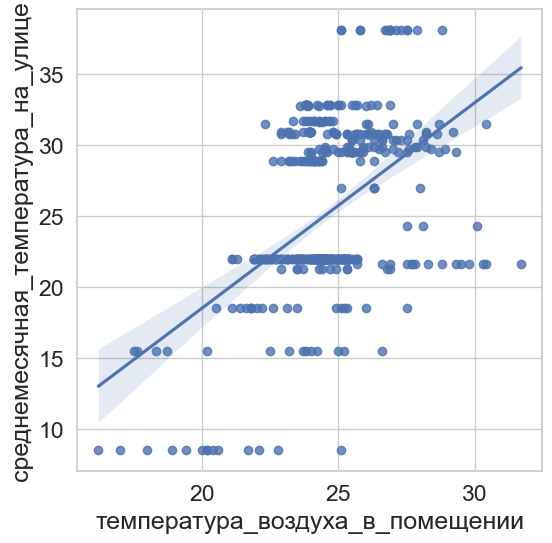

In [49]:
temp_df = df[['среднемесячная_температура_на_улице', 'температура_воздуха_в_помещении']].copy().dropna()

plt.figure(figsize=(6,6))
sns.regplot(data=temp_df, x='температура_воздуха_в_помещении', y='среднемесячная_температура_на_улице')

<Axes: xlabel='время_года', ylabel='температура_воздуха_в_помещении'>

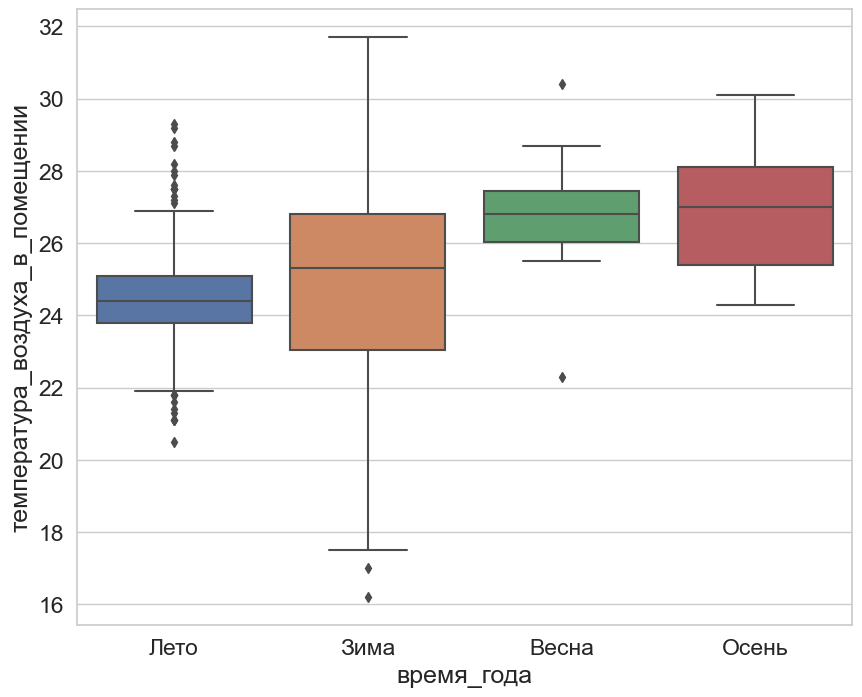

In [50]:
temp_df = df[['время_года', 'температура_воздуха_в_помещении']].copy().dropna()

plt.figure(figsize=(10,8))
sns.boxplot(data=temp_df, x='время_года', y='температура_воздуха_в_помещении')

<Axes: xlabel='город', ylabel='температура_воздуха_в_помещении'>

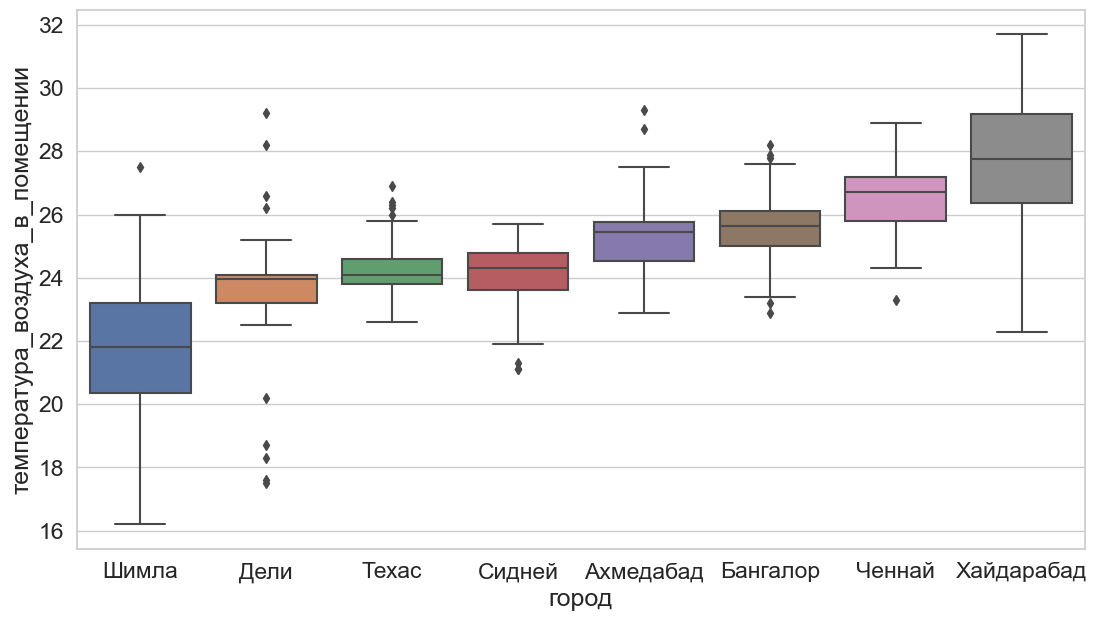

In [51]:
temp_df = df[['город', 'температура_воздуха_в_помещении']].copy().dropna()

grouped = temp_df.groupby('город')['температура_воздуха_в_помещении'].median().sort_values().index

plt.figure(figsize=(13, 7))
sns.boxplot(data=temp_df, x='город', y='температура_воздуха_в_помещении', order=grouped)

Обратимся к этим корреляциям, когда будем делать выводы по работе и подготавливать регрессионную модель.

## Есть ли разница между средней комфортной температурой для разных возрастных групп

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [52]:
gp = df[df['ощущение_температуры_(bool)'] == 1].groupby(['возрастная_группа'])['температура_воздуха_в_помещении']
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллеса')

krus = stats.kruskal(*groups)
print(krus)

if krus[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что у разных возрастных групп разная средняя комфортная температура.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что у разных возрастных групп разная средняя комфортная температура.')

Распределение ненормальное, используем критерий Красскела-Уоллеса
KruskalResult(statistic=7.191904642295867, pvalue=0.027434544234999518)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что у разных возрастных групп разная средняя комфортная температура.


Тем не менее, p-значение оказалось достаточно низким для того, чтобы утверждать что разница есть. Хотя стоит понимать, что на практике добиваться температуры в помещении с точностью менее одного градуса очень проблематично, поэтому этот вывод носит чисто символический характер.

## Влияет ли способ охлаждения на оценку комфорта

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [53]:
df['способ_охлаждения'].value_counts()

способ_охлаждения
Кондиционирование    349
Вентиляция           133
Name: count, dtype: int64

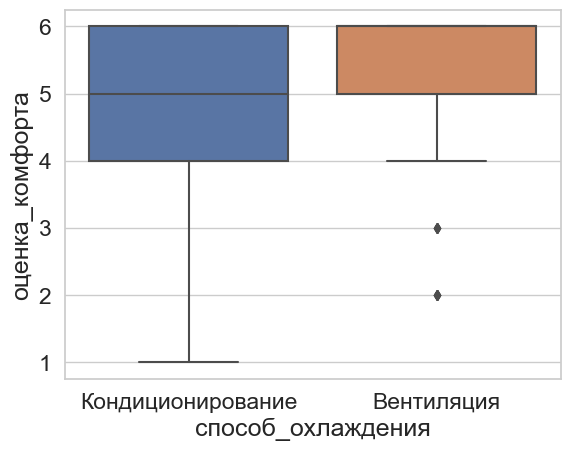

Распрление нормальное?:  False
pvalue = 0.0065189025397396246
5.0 6.0


In [54]:
temp_df = df[['способ_охлаждения', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='способ_охлаждения', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: способ охлаждения - номинальная (2 уровня), оценка комфорта - количественная
# Проверка как распределена оценка комфорта
g1 = temp_df[temp_df['способ_охлаждения'] == 'Вентиляция']['оценка_комфорта']
g2 = temp_df[temp_df['способ_охлаждения'] == 'Кондиционирование']['оценка_комфорта']

print("Распрление нормальное?: ", stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05)

# Распределение ненормальное, поэтому применяем критерий Манна-Уитни

print("pvalue =", stats.mannwhitneyu(g1, g2)[1])

print(g2.median(), g1.median())

pvalue получилось менее 0.05, значит мы можем отвергнуть нулевую гипотезу о том, что эффекта нет. **Тогда мы принимаем альтернативную гипотезу, что способ охлаждения влияет на оценку комфорта. Причем клиенты больше довольны вентиляцией, чем кондиционированием.**

## Влияние пола на оценку комфорта

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

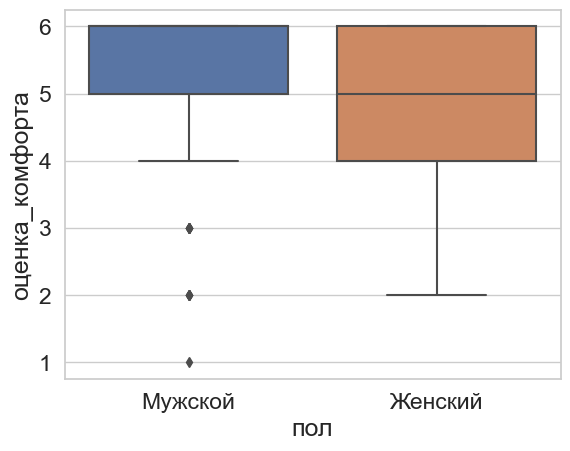

Распрление нормальное?:  False
pvalue = 0.12111267889388343


In [55]:
temp_df = df[['пол', 'оценка_комфорта']].copy()
temp_df = temp_df.dropna()

sns.boxplot(x='пол', y='оценка_комфорта', data=temp_df)
plt.show()

# Шкалы разные: пол - номинальная (2 уровня), оценка комфорта - количественная
# Проверим, как распределена оценка комфорта
g1 = temp_df[temp_df['пол'] == 'Мужской']['оценка_комфорта']
g2 = temp_df[temp_df['пол'] == 'Женский']['оценка_комфорта']

print("Распрление нормальное?: ", stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05)

# Распределение ненормальное, поэтому применяем метод Манна-Уитни

print("pvalue =", stats.mannwhitneyu(g1, g2)[1])

pvalue получилось более 0.05, значит мы не можем отвергнуть нулевую гипотезу о том, что фактор и отклик как-либо зависимы. То есть **подтвердить влияние пола на оценку комфорта невозможно при наших данных.**

## Влияет ли возрастная группа на оценку комфорта
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

<Axes: xlabel='возрастная_группа', ylabel='оценка_комфорта'>

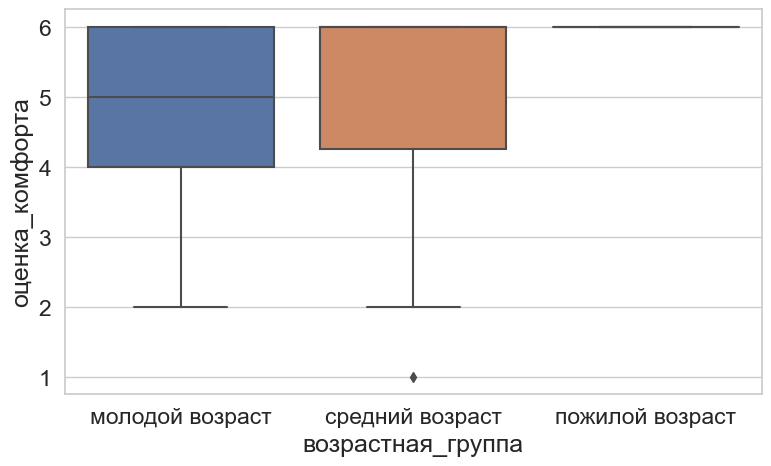

In [56]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='возрастная_группа', y='оценка_комфорта', ax=ax)

Поскольку `возрастная_группа` представлена в виде категориальной шкалы, а `оценка_комфорта` в количественной, то будем использовать критерий Красскела-Уоллеса или ANOVA. Для это определим нормальность распределения в столбце `оценка_комфорта` 

Распределение ненормальное, используем критерий Красскела-Уоллеса


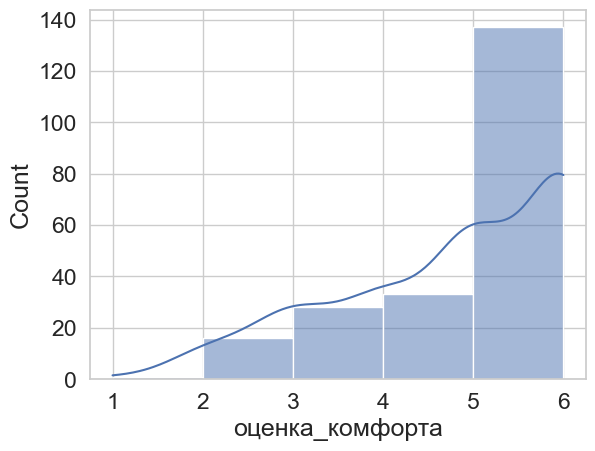

In [57]:
sns.histplot(df, x='оценка_комфорта', kde=True, bins=5)

gp = df.groupby('возрастная_группа')['оценка_комфорта']
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллеса')

In [58]:
krus = stats.kruskal(*groups)
krus

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)

In [59]:
if krus[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что возрастная группа влияет на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что возрастная группа \033[1mвлияет\033[0m на оценку комфорта.')

Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что возрастная группа влияет на оценку комфорта.


## Взаимосвязь между количеством рекламаций и оценкой комфорта
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

корелляция и pvalue:  SignificanceResult(statistic=-0.5698346757909493, pvalue=6.576564545436688e-20)


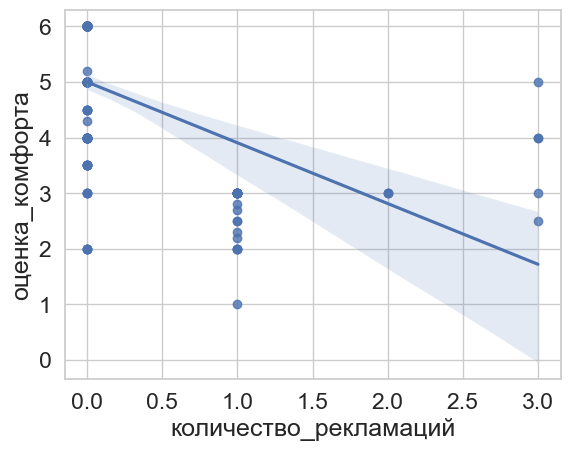

In [60]:
temp_df = df[['оценка_комфорта', 'количество_рекламаций']].copy().dropna()

if stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05 and stats.shapiro(temp_df['количество_рекламаций'])[1] > 0.05:
    # применяем метод Пирсона
    print("корелляция и pvalue: ", stats.pearsonr(temp_df['оценка_комфорта'], temp_df['количество_рекламаций']))
else:
    # применяем метод Спирмена
    print("корелляция и pvalue: ", stats.spearmanr(temp_df['оценка_комфорта'], temp_df['количество_рекламаций']))

sns.regplot(df, x='количество_рекламаций', y='оценка_комфорта')
plt.show()

Корреляция (0.5) не сильная, однако и не нулевая (можно сказать средняя). Pvalue намного меньше 0.05, поэтому мы можем доверять полученной корреляции. ***То есть взаимосвязь есть, однако она не сильная. Чем больше рекламаций, тем хуже оценка комфорта.***

## Проверить гипотезу о том, что средняя оценка комфорта отличается в зависимости от страны
- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

<Axes: xlabel='страна', ylabel='оценка_комфорта'>

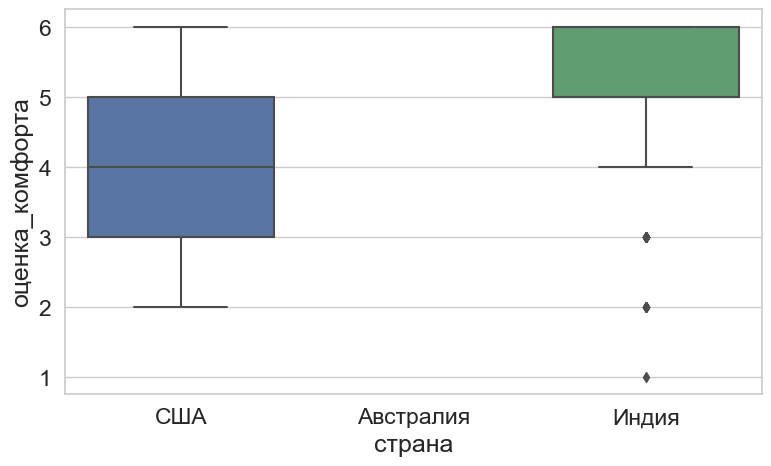

In [61]:
fig, ax = plt.subplots(figsize=(9,5))
sns.boxplot(df, x='страна', y='оценка_комфорта', ax=ax)

По графику не трудно заметить, что средняя оценка у Индии больше чем у США, а у Австралии вообще нет оценок.
Впрочем, это можно подтвердить аналитически:

In [62]:
temp_df = df[['страна', 'оценка_комфорта']].copy().dropna()

gp = temp_df.groupby('страна')
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллиса')
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что средняя оценка комфорта отличается в зависимости от страны.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что средняя оценка комфорта отличается в зависимости от страны.')

Распределение ненормальное, используем критерий Красскела-Уоллиса
KruskalResult(statistic=142.9999999999999, pvalue=5.878017999154324e-33)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что средняя оценка комфорта отличается в зависимости от страны.


Итак, средняя оценка комфорта ***отличается в зависимости от страны***.

## Выдвинуть и проверить гипотезу по влиянию разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха

### Оценка комфорта

**Гипотеза**
> **Фактор Cреднемесячная температура на улице** влияет на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [63]:
# Поскольку колонки среднемесячная_температура_на_улице и оценка_комфорта представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['среднемесячная_температура_на_улице', 'оценка_комфорта']].copy().dropna()

if stats.shapiro(temp_df['среднемесячная_температура_на_улице'])[1] > 0.05 and stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05:
    # применяем метод Пирсона
    temp = stats.pearsonr(temp_df['среднемесячная_температура_на_улице'], temp_df['оценка_комфорта'])
else:
    # применяем метод Спирмена
    temp = stats.spearmanr(temp_df['среднемесячная_температура_на_улице'], temp_df['оценка_комфорта'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств чтобы сказать, что фактор среднемесячная температура на улице влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств чтобы сказать, что фактор среднемесячная температура на улице \033[1mвлияет\033[0m на оценку комфорта.')
print('Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта. Модуль коэфицента корреляции') 
print('приблизительно равен 0.3, что говорит об очень слабой взаимосвязи ')

SignificanceResult(statistic=-0.3041926731895143, pvalue=5.560470987577545e-06)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств чтобы сказать, что фактор среднемесячная температура на улице влияет на оценку комфорта.
Также можно заметить, что показатель кореляции является отрицательным, что означает, что чем ниже температура, тем больше оценка комфорта. Модуль коэфицента корреляции
приблизительно равен 0.3, что говорит об очень слабой взаимосвязи 


### Ощущение температуры

**Гипотеза**
> Вес респондента влияет на его ощущение температуры  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [64]:
# Поскольку колонки среднемесячная_температура_на_улице и ощущение_температуры представленны одинаковыми типами
# Так как обе колонки представлены колличественными типами, то будем использовать корреляцию пирсона
temp_df = df[['вес', 'ощущение_температуры']].copy().dropna()

if stats.shapiro(temp_df['вес'])[1] > 0.05 and stats.shapiro(temp_df['ощущение_температуры'])[1] > 0.05:
    # применяем метод Пирсона
    temp = stats.pearsonr(temp_df['вес'], temp_df['ощущение_температуры'])
else:
    # применяем метод Спирмена
    temp = stats.spearmanr(temp_df['вес'], temp_df['ощущение_температуры'])

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что вес респондента \033[1mвлияет\033[0m на ощущение температуры.')

SignificanceResult(statistic=0.03867716091598628, pvalue=0.5754602847830063)
Поскольку p-значение не меньше 0,05, мы не можем отвергнуть нулевую гипотезу.
Следовательно, у нас нет достаточных доказательств того, что вес респондента влияет на ощущение температуры.


## Влияние разных факторов на оценку комфорта/ощущение температуры/ощущение движения воздуха

### Оценка комфорта

**Гипотеза**
> **Категории влажности** влияют на **оценку комфорта**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [65]:
# Поскольку колонки rh_кат и оценка_комфорта представленны разными типами
# А в rh_кат более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллиса

temp_df = df[['rh_кат', 'оценка_комфорта']].copy().dropna()

gp = temp_df.groupby('rh_кат')
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    print('Распределение \033[1mнормальнное\033[0m, исппользуем ANOVA')
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    print('Распределение \033[1mненормальное\033[0m, используем критерий Красскела-Уоллиса')
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что категории относительной влажности влияют на оценку комфорта.')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что категории относительной влажности \033[1mвлияет\033[0m на оценку комфорта.')

Распределение ненормальное, используем критерий Красскела-Уоллиса
KruskalResult(statistic=38.52266293274033, pvalue=4.314296910953422e-09)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что категории относительной влажности влияет на оценку комфорта.


### Ощущение температуры

**Гипотеза**
> Принадлежность респондента к **возрастной группе** влияет на его **ощущение температуры**  

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [66]:
# Поскольку колонки возрастная_группа и ощущение_температуры представленны разными типами
# А в возрастная_группе более двух уровней, будем использовать ANOVA или критерий Красскела-Уоллеса

temp_df = df[['возрастная_группа', 'ощущение_температуры']].copy().dropna()

gp = temp_df.groupby("возрастная_группа")
groups = [v for v in gp.groups.values()]

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

if temp[1] >= 0.05:
    print('Поскольку p-значение не меньше 0,05, мы \033[1mне\033[0m можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас нет достаточных доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры')
else:
    print('Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.\n'
          'Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры.')

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)
Поскольку p-значение меньше 0,05, мы можем отвергнуть нулевую гипотезу.
Следовательно, у нас достаточно доказательств того, что принадлежность к возрастной группе влияет на оценку ощущения температуры.


### Ощущение движения воздуха

**Гипотеза**
> Принадлежность респондента к **возрастной группе** влияет на его **ощущения движения воздуха**

- Нулевая гипотеза: влияния/эффекта нет
- Альтернативная гипотеза: влияние/эффект есть

In [67]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'возрастная_группа']].copy().dropna()

crosstab = pd.crosstab(temp_df['ощущение_движения_воздуха_(bool)'], temp_df['возрастная_группа'])
chi2 = stats.chi2_contingency(crosstab)[0]
n = crosstab.sum().sum()
phi2 = chi2 / n
kramer = np.sqrt(phi2 / (min(crosstab.shape) - 1))

print("k =", kramer)

k = 0.17909519344181102


Корреляция есть, но она очень слабая. Поэтому нельзя отвергнуть нулевую гипотезу.
Следовательно, на основании имеющихся данных ***нельзя сказать, что принадлежность респондента к возрастной группе влияет на его ощущения движения воздуха***

## Какая скорость воздуха будет комфортной, и есть ли корреляция оценки воздуха с его реальной скоростью?

<Axes: xlabel='ощущение_движения_воздуха_(bool)', ylabel='скорость_воздуха'>

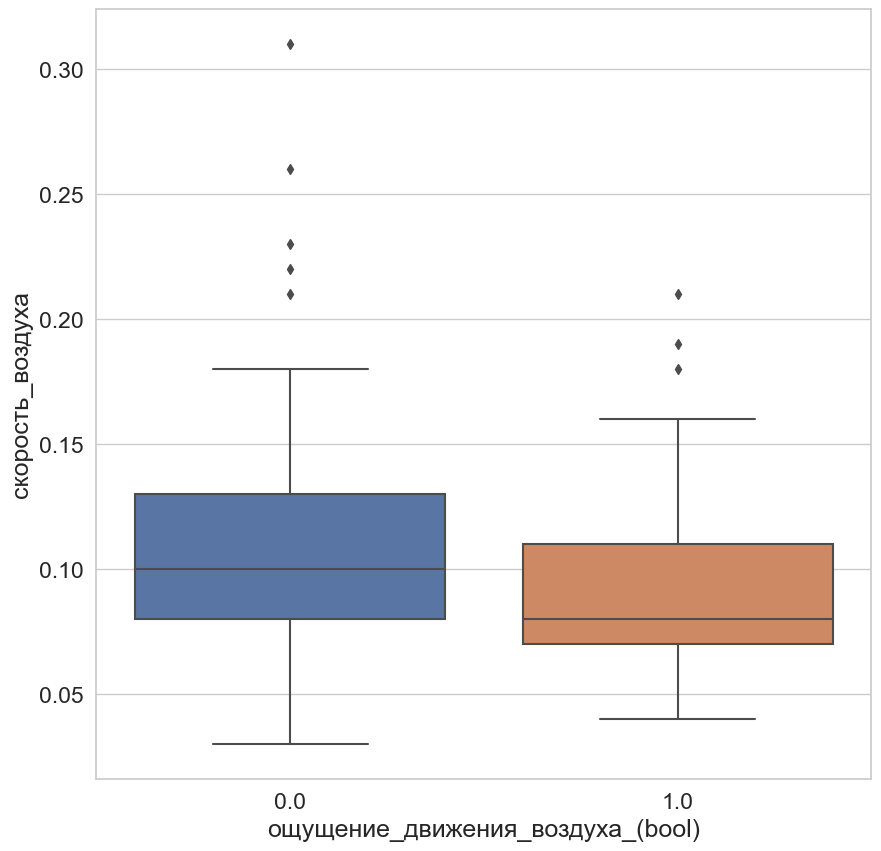

In [68]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'скорость_воздуха']].copy().dropna()

plt.figure(figsize=(10,10))
sns.boxplot(data=temp_df, x='ощущение_движения_воздуха_(bool)', y='скорость_воздуха')

In [69]:
g1 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 1]['скорость_воздуха']
g2 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 0]['скорость_воздуха']

if stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем метод Манна-Уитни, чтобы исследовать корреляцию

_, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
print('pvalue = ', p)

распределение ненормальное
pvalue =  0.004529414866412486


pvalue меньше 0.05, поэтому мы отвергаем нулевую гипотезу и принимаем альтернативную, что ***распределния не равны и имеют статистически значимые отличия*** </br> Также по графику обратим внимание на медианы и распределение в целом: ***чем меньше скорость воздуха, тем больше шанс, что респондента устраивает скорость воздуха в помещении***

<Axes: xlabel='оценка_комфорта', ylabel='скорость_воздуха'>

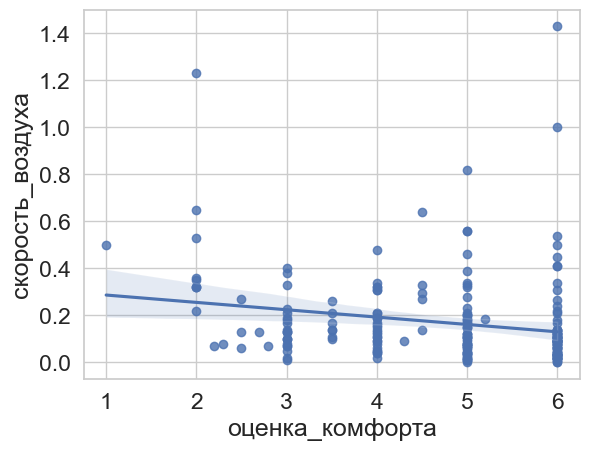

In [70]:
temp_df = df[['оценка_комфорта', 'скорость_воздуха']].copy().dropna()

sns.regplot(data=temp_df, x='оценка_комфорта', y='скорость_воздуха')

In [71]:
if stats.shapiro(temp_df['скорость_воздуха'])[1] > 0.05 and stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем корреляцию Спирмена

k, p = stats.spearmanr(temp_df['скорость_воздуха'], temp_df['оценка_комфорта'])
print('k=', k, '  pvalue = ', p)

распределение ненормальное
k= -0.2988009366199691   pvalue =  8.272461315539227e-06


Pvalue меньше 0.05, то есть эффект есть, однако значимой корреляции между скоростью воздуха и оценкой комфорта нет (0.29 не сильная корреляция), то есть: ***скорость воздуха влияет на оценку комфорта, но не сильно***

# Регрессионное моделирование
Чтобы построить рабочую модель для предсказания температуры, необходимо выявить все факторы, которые могут влиять на температуру, то есть найти корреляции между факторами. </br>
Нужные факторы можно выбрать, основываясь на подтвержденные гипотезы и сильные корреляции выше. </br></br>
Для построения модели будем использовать такие факторы как: **время года, город, способ охлаждения и среднемесячная температура**, поскольку эти факторы имеют статистически значимые корреляции с температурой воздуха в помещении(pvalue меньше 0.05) и эти факторы не будут являться утечкой, так как эти данные можно легко найти при необходимости. </br>

In [72]:
temp_df = df[['время_года', 'город', 'способ_охлаждения', 'среднемесячная_температура_на_улице', 'температура_воздуха_в_помещении']].copy()

temp_df.head(7)

,время_года,город,способ_охлаждения,среднемесячная_температура_на_улице,температура_воздуха_в_помещении
0,Лето,Техас,Кондиционирование,28.900000,22.900000
1,Лето,Техас,Кондиционирование,28.888889,23.777778
2,Лето,Техас,Кондиционирование,32.800000,25.600000
3,Лето,Техас,Кондиционирование,28.900000,24.200000
4,Лето,Техас,Кондиционирование,32.800000,23.800000
5,Лето,Техас,Кондиционирование,28.900000,24.000000
6,Лето,Техас,Кондиционирование,32.800000,24.700000


MAE: 1.0582396546060133
MSE: 1.9665522257593204
RMSE: 1.402338128184255
R2: 0.45311454745311386


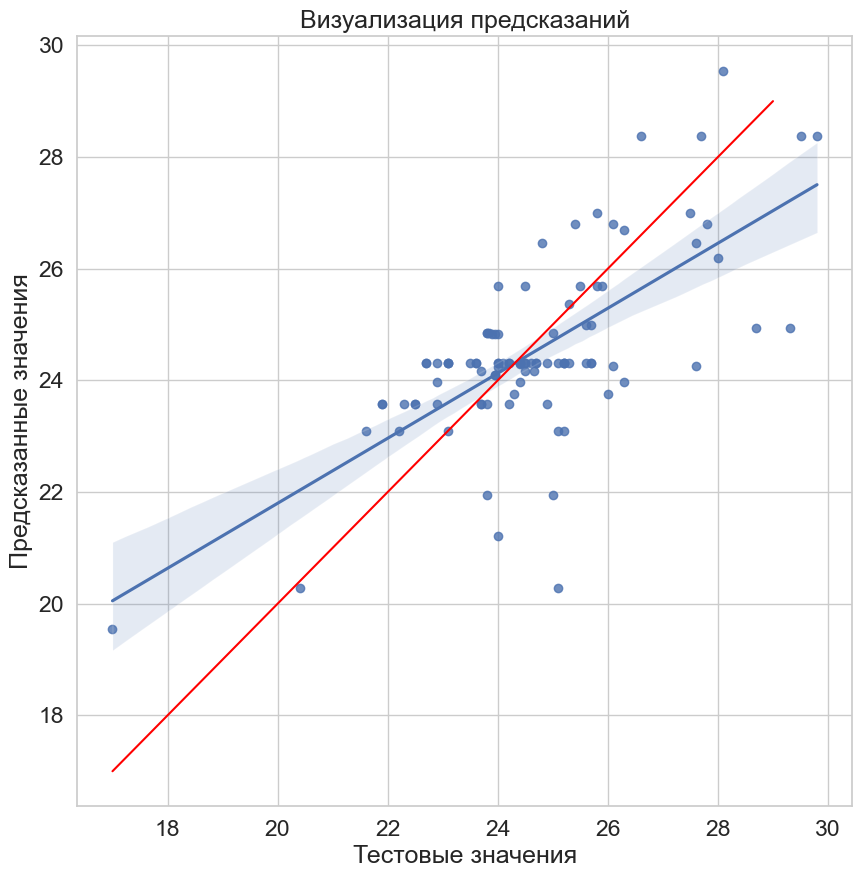

In [73]:
# Тестовая и тренировочные выборки
X_train, X_test, y_train, y_test = train_test_split(temp_df[['время_года', 'город', 'способ_охлаждения', 'среднемесячная_температура_на_улице']],
                                                    temp_df['температура_воздуха_в_помещении'], test_size=0.2, random_state=42)

# Кодирование категориальных признаков
encoder = OneHotEncoder(handle_unknown='ignore')
encoder.fit(X_train[['время_года', 'город', 'способ_охлаждения', 'среднемесячная_температура_на_улице']])
X_train = encoder.transform(X_train[['время_года', 'город', 'способ_охлаждения', 'среднемесячная_температура_на_улице']])
X_test = encoder.transform(X_test[['время_года', 'город', 'способ_охлаждения', 'среднемесячная_температура_на_улице']])

# Обучение модели
model = LinearRegression()
model.fit(X_train, y_train)

# Предсказание
y_pred = model.predict(X_test)

# Оценка модели
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2:', metrics.r2_score(y_test, y_pred))

# Визуализация

plt.figure(figsize=(10,10))
sns.regplot(x=y_test, y=y_pred)
plt.plot(np.arange(17, 30), np.arange(17, 30), color='red')
plt.xlabel('Тестовые значения')
plt.ylabel('Предсказанные значения')
plt.title('Визуализация предсказаний')
plt.show()

По итогу модель имеет не очень высокую точность: 
- Mean absolute error (MAE) - Средняя абсолютная ошибка модели
- Mean squeared error (MSE) - Среднеквадратичная ошибка
- Root-mean-square error (RMSE) - Среднеквадратическое отклонение
- R2 - насколько правильно работает модель от 0 (не работает) до 1 (идеально)

SignificanceResult(statistic=0.330426347653001, pvalue=9.646282301215535e-14)


<Axes: xlabel='температура_воздуха_в_помещении', ylabel='среднемесячная_температура_на_улице'>

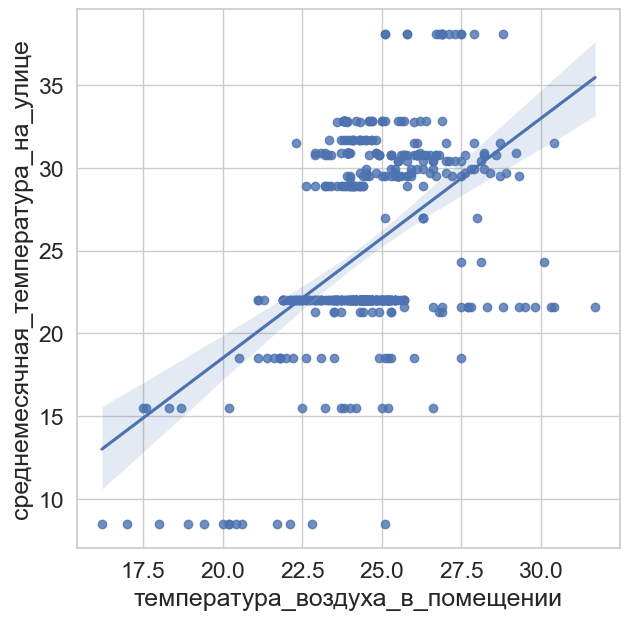

In [74]:
# Проверка корреляции средне месячной температуры на улице и температуры в помещении
temp_df = df[['среднемесячная_температура_на_улице', 'температура_воздуха_в_помещении']].copy().dropna()

if stats.shapiro(temp_df['среднемесячная_температура_на_улице'])[1] > 0.05 and stats.shapiro(temp_df['температура_воздуха_в_помещении'])[1] > 0.05:
    # применяем метод Пирсона
    temp = stats.pearsonr(temp_df['среднемесячная_температура_на_улице'], temp_df['температура_воздуха_в_помещении'])
else:
    # применяем метод Спирмена
    temp = stats.spearmanr(temp_df['среднемесячная_температура_на_улице'], temp_df['температура_воздуха_в_помещении'])

print(temp)

plt.figure(figsize=(7,7))
sns.regplot(data=temp_df, x='температура_воздуха_в_помещении', y='среднемесячная_температура_на_улице')

KruskalResult(statistic=49.894091356269875, pvalue=8.415054004994353e-11)


<Axes: xlabel='время_года', ylabel='температура_воздуха_в_помещении'>

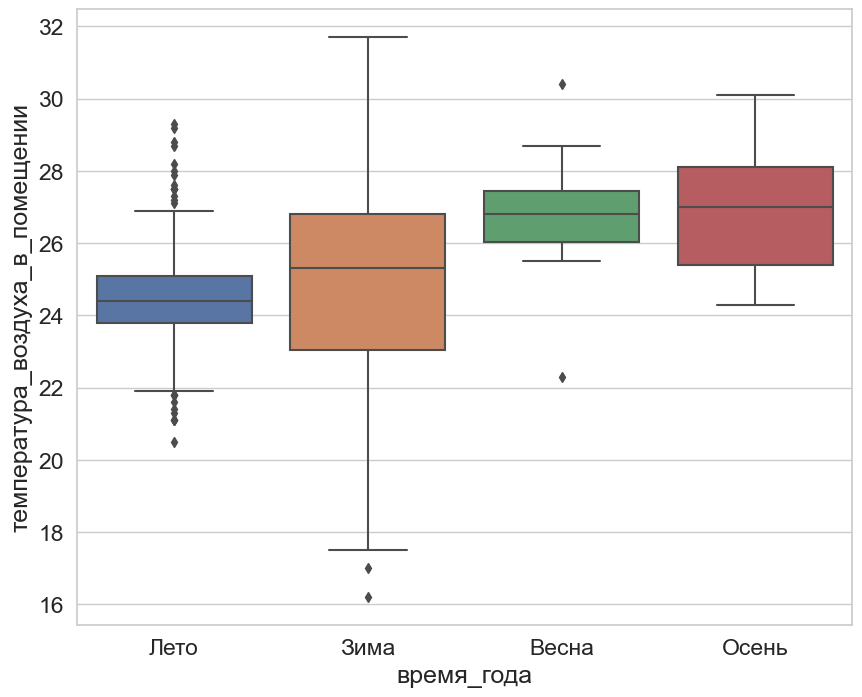

In [75]:
temp_df = df[['время_года', 'температура_воздуха_в_помещении']].copy().dropna()

groups = []
for i in temp_df['время_года'].unique():
    groups.append(temp_df[temp_df['время_года'] == i]['температура_воздуха_в_помещении'])

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*groups)
else:
    temp = stats.kruskal(*groups)

print(temp)

plt.figure(figsize=(10,8))
sns.boxplot(data=temp_df, x='время_года', y='температура_воздуха_в_помещении')

KruskalResult(statistic=214.25120619373243, pvalue=1.0946031973906458e-42)


<Axes: xlabel='город', ylabel='температура_воздуха_в_помещении'>

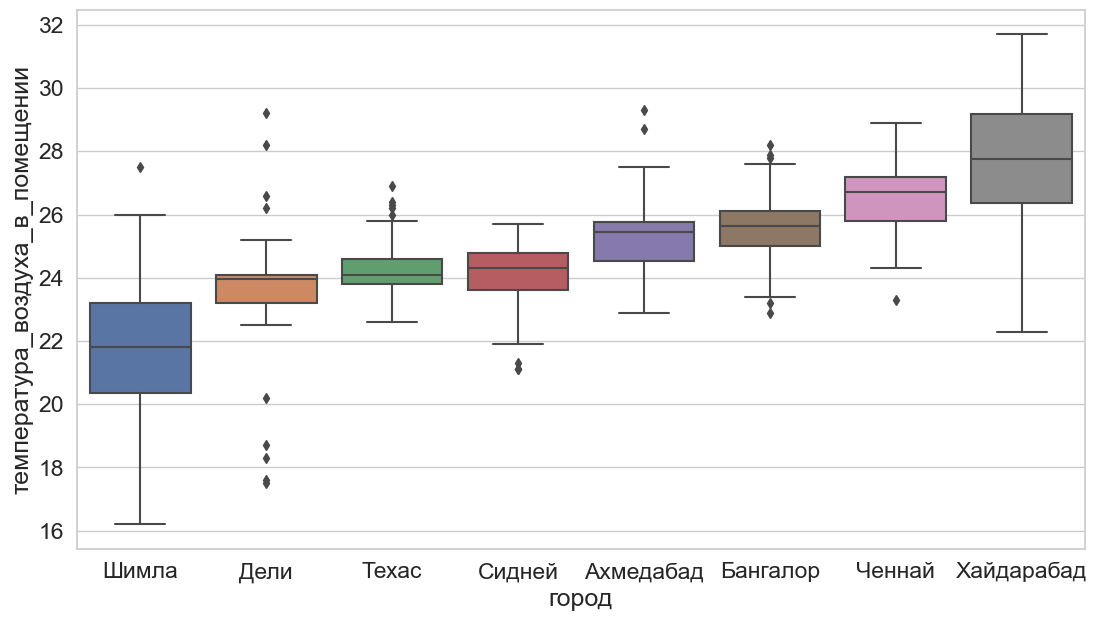

In [76]:
temp_df = df[['город', 'температура_воздуха_в_помещении']].copy().dropna()

groups = []
for i in temp_df['город'].unique():
    groups.append(temp_df[temp_df['город'] == i]['температура_воздуха_в_помещении'])

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*groups)
else:
    temp = stats.kruskal(*groups)

print(temp)

grouped = temp_df.groupby('город')['температура_воздуха_в_помещении'].median().sort_values().index

plt.figure(figsize=(13, 7))
sns.boxplot(data=temp_df, x='город', y='температура_воздуха_в_помещении', order=grouped)

KruskalResult(statistic=10.57106480574741, pvalue=0.00114871539757397)


<Axes: xlabel='способ_охлаждения', ylabel='температура_воздуха_в_помещении'>

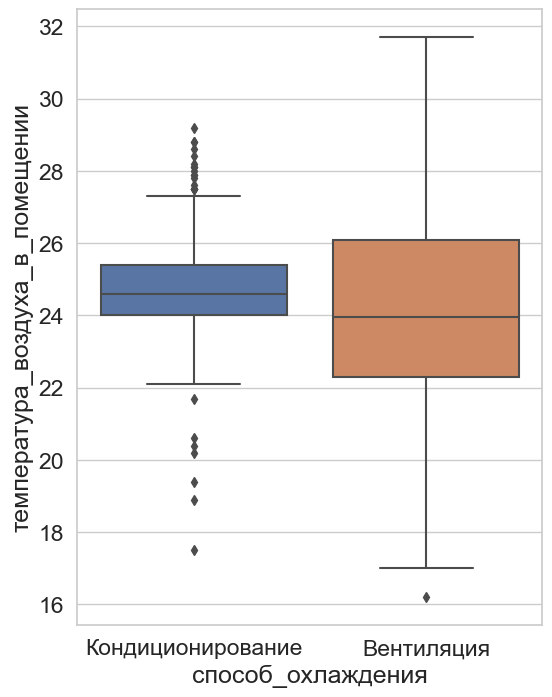

In [77]:
temp_df = df[['способ_охлаждения', 'температура_воздуха_в_помещении']].copy().dropna()

groups = []
for i in temp_df['способ_охлаждения'].unique():
    groups.append(temp_df[temp_df['способ_охлаждения'] == i]['температура_воздуха_в_помещении'])

flag_normal = True

for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*groups)
else:
    temp = stats.kruskal(*groups)

print(temp)

plt.figure(figsize=(6, 8))
sns.boxplot(data=temp_df, x='способ_охлаждения', y='температура_воздуха_в_помещении')

У корреляций выше pvalue меньше 0.05, поэтому мы можем строить модель на их основе.

# Дополнительные исследования и выводы

## Кондиционирование и вентиляция

Рассмотрим корреляцию: климат и способ охлаждения с оценкой комфорта, для этого создадим дополнительный фактор:

In [78]:
df['климат_способ'] = df['климат'] + '_' + df['способ_охлаждения']
temp_df = df[['климат_способ', 'оценка_комфорта']].copy().dropna()

if stats.shapiro(temp_df.оценка_комфорта)[1] >= 0.5:
    temp = stats.f_oneway(*(v for v in gp.groups.values()))
else:
    temp = stats.kruskal(*(v for v in gp.groups.values()))

print(temp)

KruskalResult(statistic=7.2979402446489985, pvalue=0.026017910250498436)


pvalue менее 0.05 - **корреляция статистически значимая**

<Axes: xlabel='оценка_комфорта', ylabel='климат_способ'>

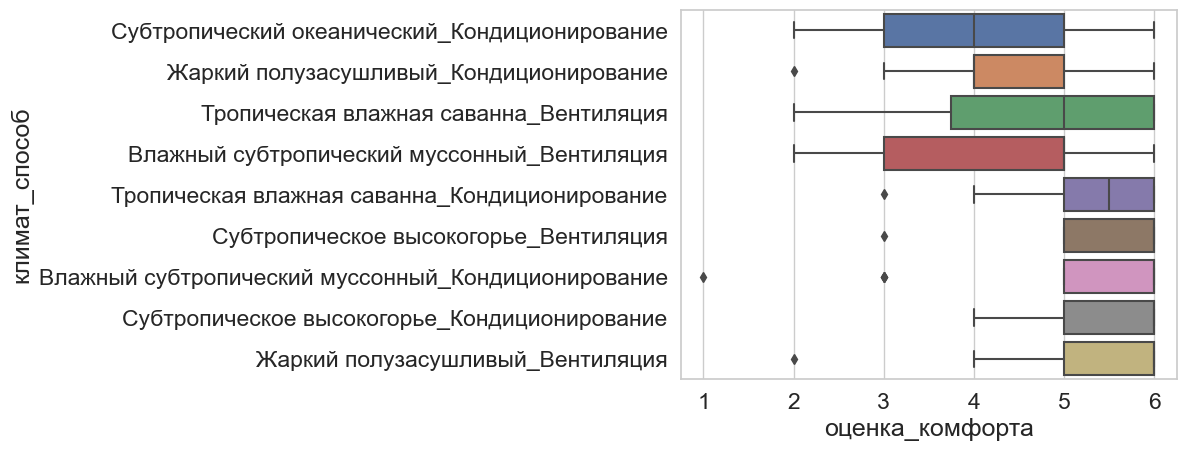

In [79]:
# Отсортируем по медианам, чтобы было нагляднее
sns.boxplot(temp_df, x='оценка_комфорта', y='климат_способ', order=sorted(temp_df['климат_способ'].unique(), key=lambda x: temp_df[temp_df['климат_способ'] == x]['оценка_комфорта'].median()))

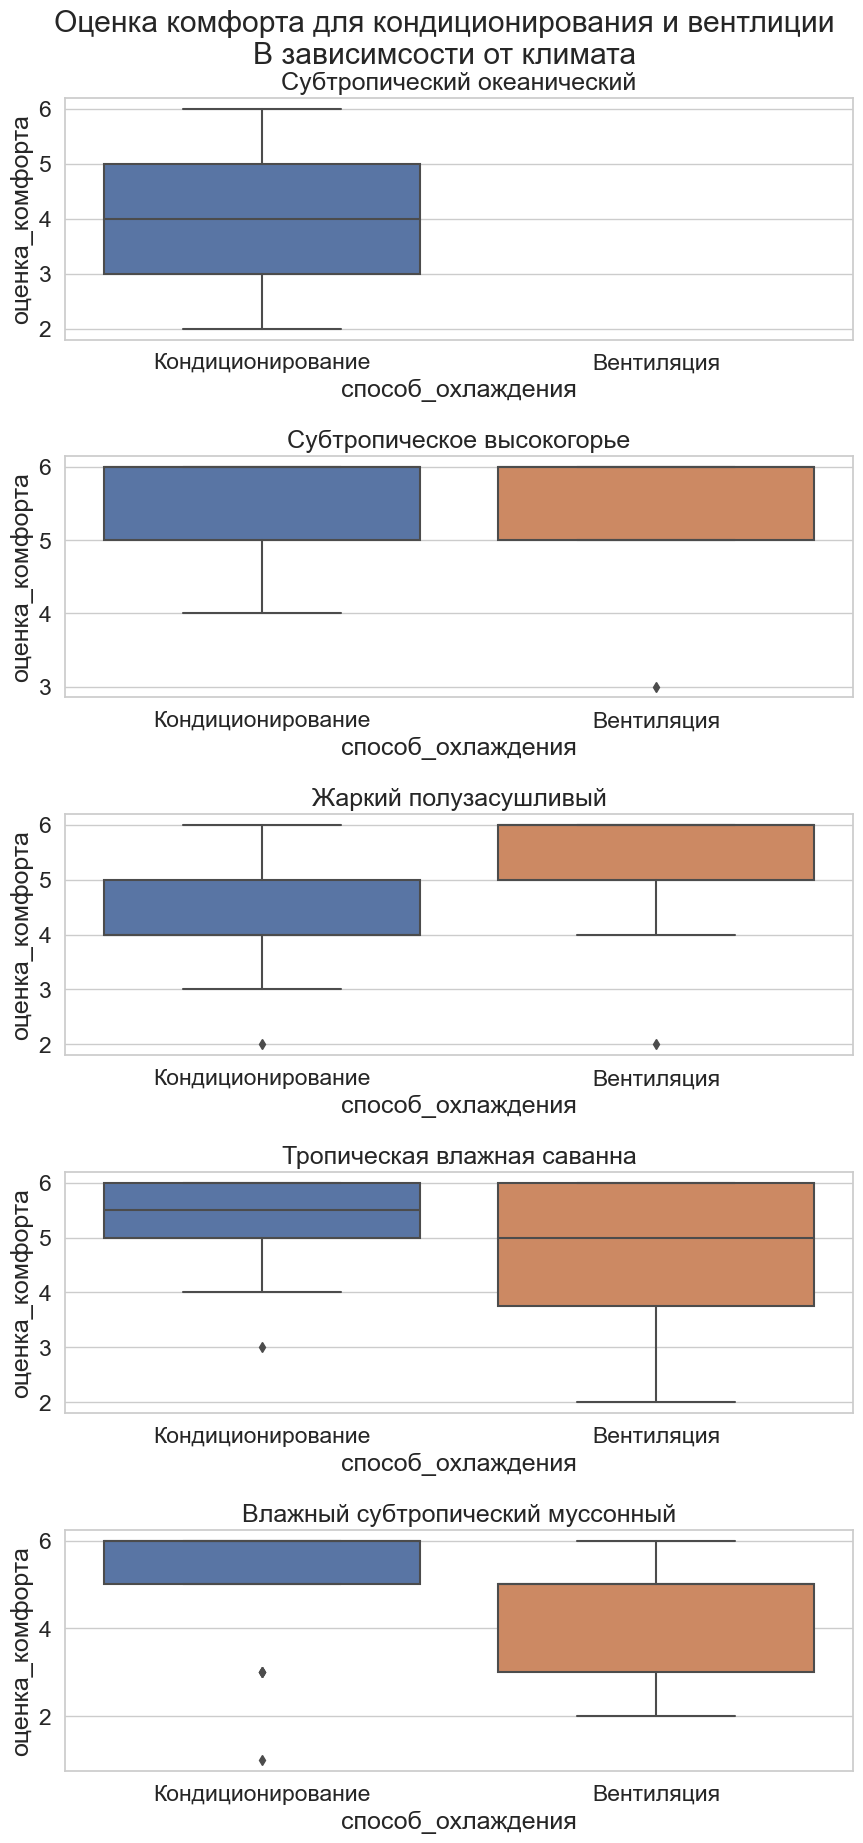

In [80]:
fig, ax = plt.subplots(len(df.климат.unique()), 1)
fig.set_figheight(20)
fig.set_figwidth(10)
fig.suptitle("Оценка комфорта для кондиционирования и вентлиции\nВ зависимсости от климата", y=0.935)
fig.tight_layout(pad=3.0)
for i, kl in enumerate(df.климат.unique()):
    sns.boxplot(df[df['климат'] == kl], x='способ_охлаждения', y='оценка_комфорта', ax=ax[i], order=['Кондиционирование', 'Вентиляция'])
    ax[i].set_title(kl)

In [81]:
humid = ['Тропическая влажная саванна', 'Влажный субтропический муссонный']

# Мы не берём Cубтропический океанический климат, поскольку в нём не представлен Вентиляционный тип охлаждения
temp_df = df[df['климат'] != 'Cубтропический океанический'][['климат', 'оценка_комфорта', 'способ_охлаждения']].copy().dropna()

temp_df['влажность_климата'] = temp_df['климат'].apply(lambda x: 'Влажный' if x in humid else "Сухой")
print(temp_df.groupby(['влажность_климата', 'способ_охлаждения'])['оценка_комфорта'].mean())

влажность_климата  способ_охлаждения
Влажный            Вентиляция           4.440000
                   Кондиционирование    5.250000
Сухой              Вентиляция           5.475000
                   Кондиционирование    4.733333
Name: оценка_комфорта, dtype: float64


Заметим, что в сухих климатах (жаркий полузасушливый) люди чаще предпочитают вентиляцию, а во влажных (влажный субтропический муссонный, тропическая влажная саванна) - кондиционирование. Это можно объяснить тем, что в сухих климатических зонах **кондиционирование снижает влажность до слишком низкого уровня**, в то время как **во влажных зонах кондиционирование снижает влажность до комфортного уровня**, поскольку там и так повышенная влажность.

Это происходит из-за особенностей работы кондиционера: он "осушает" воздух во время своей работы, так как влажность воздуха уходит в конденсат. 

Ниже можно взглянуть на наглядные схемы работы кондиционера и концентрацию влажности в воздухе при разных температурах:

![](https://cdn.citilink.ru/mRhMbT0wHxylifVcdlCc0sKFzrw5OeqUNS6_MFthWFk/fit/1706/1200/sm/1/plain/journal/090a3db5-fd2e-4102-96bf-8c956a71845f.jpg)

![](https://cdn.citilink.ru/yUMStECBoNKRxiaQWFioNExQv4rQ1dEswZl5c9BU948/fit/1778/1251/sm/1/plain/journal/389c6317-192d-4b3f-904c-310f7ba26e92.jpg)

Поэтому в сухих климатах стоит сконцентрироваться на вентиляции, а во влажных на кондиционировании. Или необходимо другое инженерное решение, которое сделает кондиционер более релевантным в сухих регионах.

## Города (рынки)

Конкретные города с климатом, на которые можно обратить внимание:

KruskalResult(statistic=31.824284293148537, pvalue=6.436725736532875e-06)


[Text(0, 0, 'Cубтропический океанический_Техас'),
 Text(1, 0, 'Влажный субтропический муссонный_Дели'),
 Text(2, 0, 'Жаркий полузасушливый_Ахмедабад'),
 Text(3, 0, 'Тропическая влажная саванна_Ченнай'),
 Text(4, 0, 'Субтропическое высокогорье_Шимла'),
 Text(5, 0, 'Тропическая влажная саванна_Бангалор')]

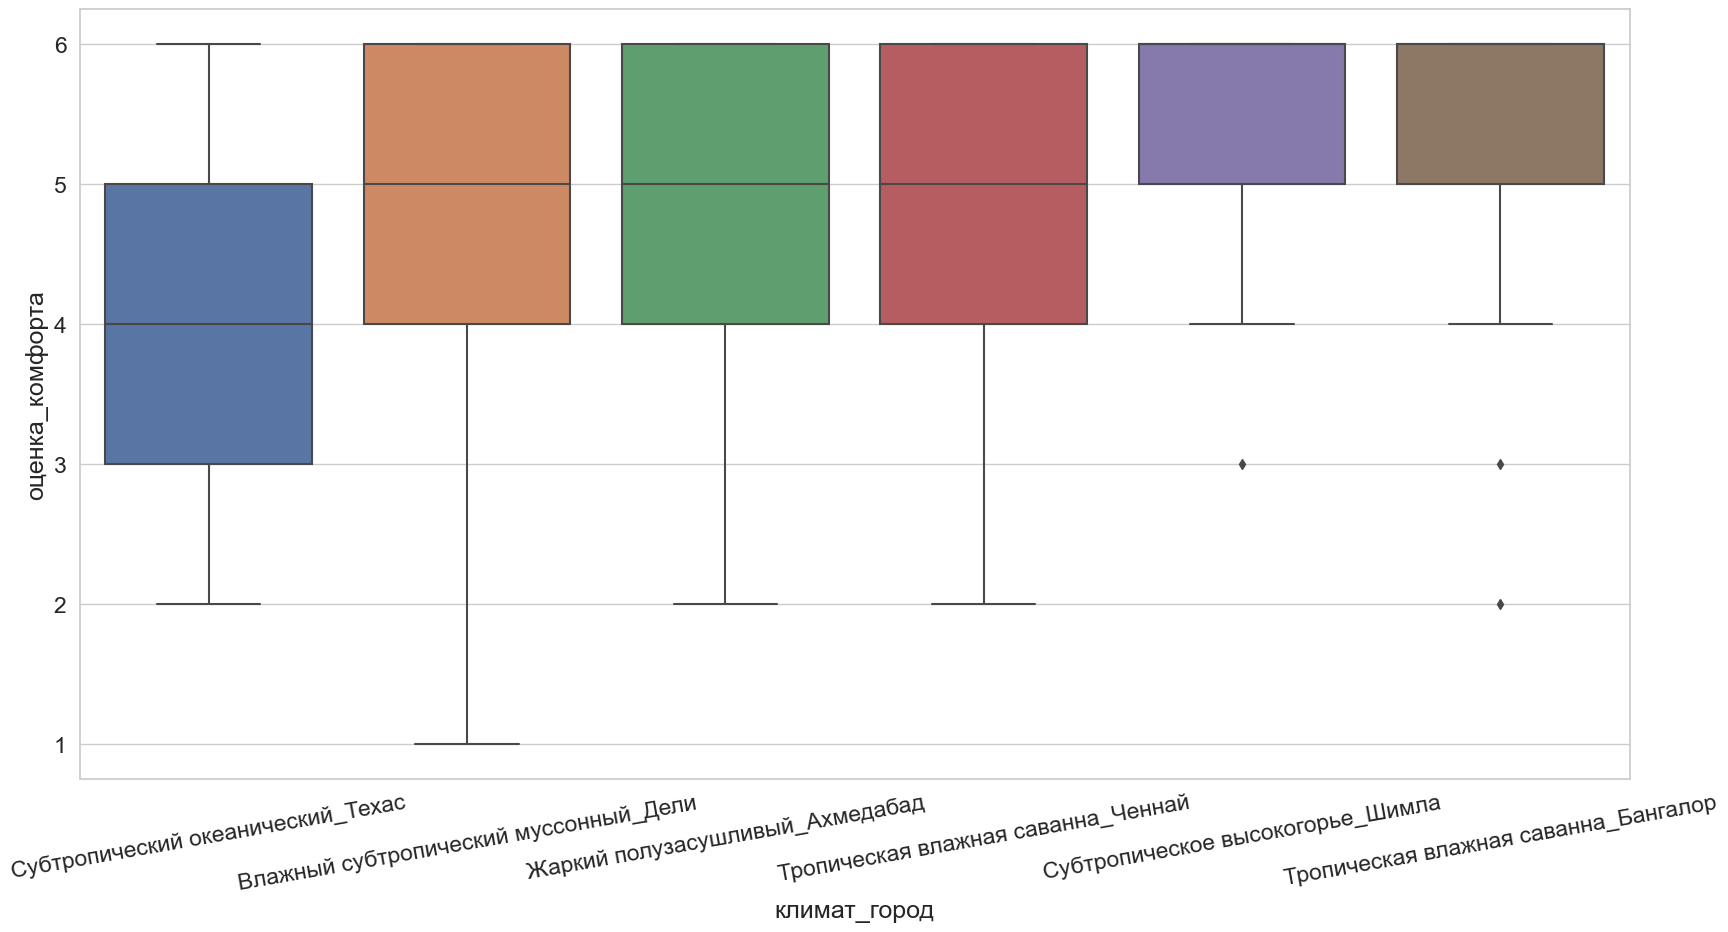

In [82]:
temp_df = df[['климат', 'город', 'оценка_комфорта']].copy().dropna()

temp_df['климат_город'] = temp_df['климат'] + '_' +  temp_df['город']

groups = []
for i in temp_df['климат_город'].unique():
    groups.append(temp_df[temp_df['климат_город'] == i]['оценка_комфорта'])

flag_normal = True
for g in groups:
    if len(g) < 3 or stats.shapiro(g)[1] <= 0.05:
        # ненормальное распределение
        # применяем метод Краскела-Уоллиса
        flag_normal = False
        break

if flag_normal:
    temp = stats.f_oneway(*groups)
else:
    temp = stats.kruskal(*groups)

print(temp)

grouped = temp_df.groupby('климат_город')['оценка_комфорта'].median().sort_values().index

fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=temp_df, x='климат_город', y='оценка_комфорта', order=grouped, ax=ax)
ax.set_xticklabels(ax.get_xticklabels(),rotation=10)

Видно как клиенты не довольны продукцией в Техасе, стоит обратить внимание на этот рынок.

## Скорость воздуха

*Повторение из доказанных гипотез:*

распределение ненормальное
pvalue =  0.004529414866412486


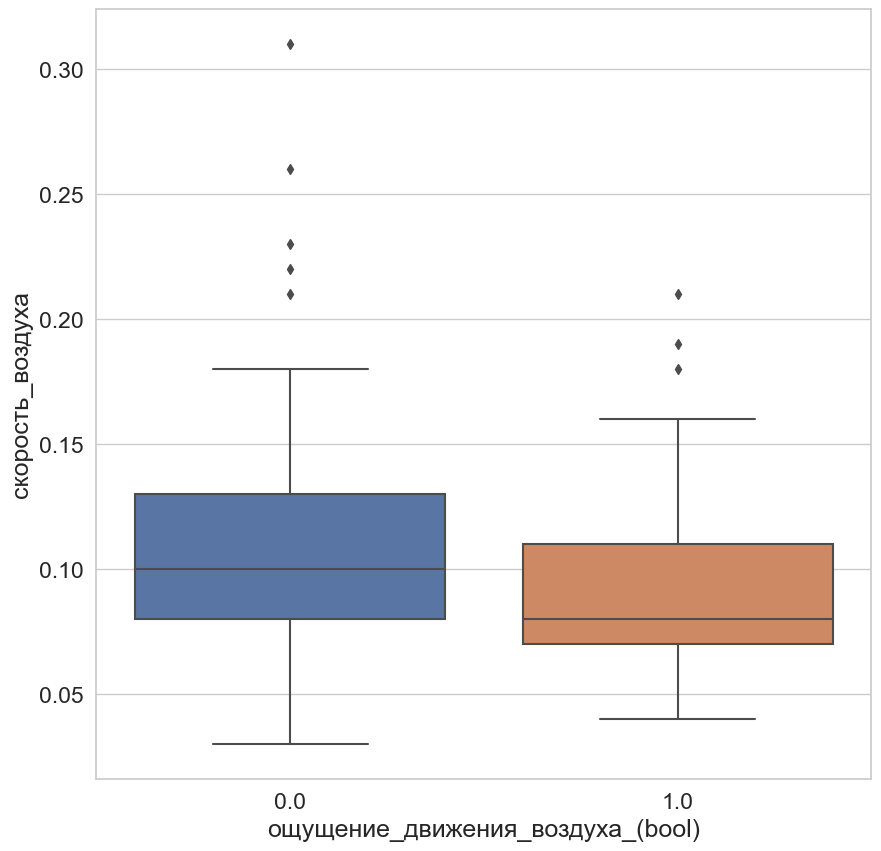

In [83]:
temp_df = df[['ощущение_движения_воздуха_(bool)', 'скорость_воздуха']].copy().dropna()

plt.figure(figsize=(10,10))
sns.boxplot(data=temp_df, x='ощущение_движения_воздуха_(bool)', y='скорость_воздуха')

g1 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 1]['скорость_воздуха']
g2 = temp_df[temp_df['ощущение_движения_воздуха_(bool)'] == 0]['скорость_воздуха']

if stats.shapiro(g1)[1] > 0.05 and stats.shapiro(g2)[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем метод Манна-Уитни, чтобы исследовать корреляцию

_, p = stats.mannwhitneyu(g1, g2, alternative='two-sided')
print('pvalue = ', p)

распределение ненормальное
k= -0.2988009366199691   pvalue =  8.272461315539227e-06


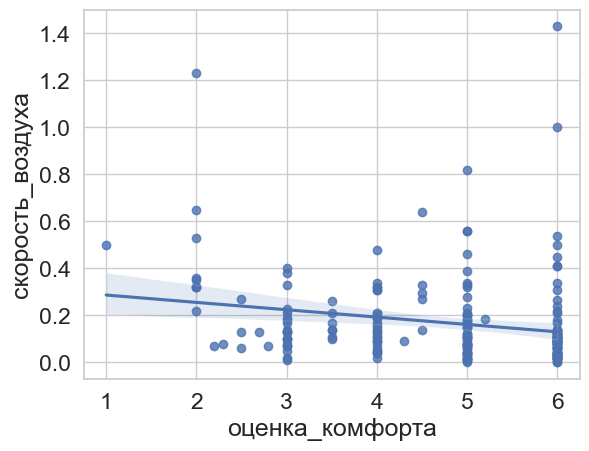

In [84]:
temp_df = df[['оценка_комфорта', 'скорость_воздуха']].copy().dropna()

sns.regplot(data=temp_df, x='оценка_комфорта', y='скорость_воздуха')

if stats.shapiro(temp_df['скорость_воздуха'])[1] > 0.05 and stats.shapiro(temp_df['оценка_комфорта'])[1] > 0.05:
    print('распределение нормальное')
else:
    print('распределение ненормальное')

# Распределение ненормальное поэтому используем корреляцию Спирмена

k, p = stats.spearmanr(temp_df['скорость_воздуха'], temp_df['оценка_комфорта'])
print('k=', k, '  pvalue = ', p)

Способ охлаждения влияет на скорость воздуха, как было доказано выше, **чем меньше скорость воздуха, тем больше клиентов довольны.** </br>Возможно стоит обратить внимание на то, **как работает кондиционер, чтобы уменьшить скорость воздуха, или устанавливать его в места, где нет людей**, чтобы на них "не дуло". Это могло бы быть хорошим местом для инвестиций, так как получится закрыть потребности клиентов новым инженерным решением.